In [120]:
import ROOT as rt
import array as arr
import math

In [2]:
# epsilon used to avoid bin edge nightmares (if you pick a value that lies on bin edge, it defaults to right bin)
EPSILON = 0.00001

In [3]:
DELTA_ETA_MAX = 1.4 - EPSILON

In [4]:
TRIG_PT_LOW = 4
TRIG_PT_HIGH = 8 - EPSILON
ASSOC_PT_LOW = 2
ASSOC_PT_HIGH = 4 - EPSILON

In [5]:
LSB_MIN = 1.085
LSB_MAX = 1.10 - EPSILON
SIG_MIN = 1.108 
SIG_MAX = 1.124 - EPSILON
RSB_MIN = 1.14
RSB_MAX = 1.155 - EPSILON

In [6]:
c = rt.TCanvas("main_canvas", "Main Canvas", 0, 10, 1920, 1080)

In [7]:
# a function to calculate parabola that passes through all three input points
def get_parabola(point_one, point_two, point_three):
    x1, x2, x3 = point_one[0], point_two[0], point_three[0]
    y1, y2, y3 = point_one[1], point_two[1], point_three[1]
    
    denom = (x1 - x2)*(x1 - x3)*(x2 - x3)
    
    A = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
    B = (x3**2 * (y1 - y2) + x2**2 * (y3 - y1) + x1**2 * (y2 - y3)) / denom
    C = (x2 * x3 * (x2 - x3) * y1 + x3 * x1 * (x3 - x1) * y2 + x1 * x2 * (x1 - x2) * y3) / denom
    
    return C, B, A
    

In [8]:
def make_mixed_corrections(same, mixed, mass_low=1.11, mass_high=1.12, is_hh=False):
    if is_hh:
        same3d = same
        same3d.Sumw2()
        mixed3d = mixed
        mixed3d.Sumw2()
    else:
        same.GetAxis(2).SetRangeUser(mass_low, mass_high)
        mixed.GetAxis(2).SetRangeUser(mass_low, mass_high)
        same3d = same.Projection(0, 1, 3)
        same3d.Sumw2()
        mixed3d = mixed.Projection(0, 1, 3)
        mixed3d.Sumw2()
        
    for zbin in range(10):
        same3d.GetZaxis().SetRange(zbin+1, zbin+1)
        same2d = same3d.Project3D("xye")
        same2d.SetName(f"same2dproj_zbin_{zbin}")

        mixed3d.GetZaxis().SetRange(zbin+1, zbin+1)
        mixed2d = mixed3d.Project3D("xye")
        mixed2d.SetName(f"mix2dproj_zbin_{zbin}")

        #scaling by average of bins adjacent to 0
        scale = 0.5*(mixed2d.Integral(mixed2d.GetXaxis().FindBin(-0.01),    #xmin
                                      mixed2d.GetXaxis().FindBin(0.01),     #xmax 
                                      mixed2d.GetYaxis().FindBin(0.0),      #ymin
                                      mixed2d.GetYaxis().FindBin(0.0)))     #ymax
        same2d.Divide(mixed2d)
        same2d.Scale(scale)
        
        if zbin == 0:
            same2d_total = same2d.Clone("2dproj_total")
        else:
            same2d_total.Add(same2d)

    return same2d_total
    

# 0-20 setup

In [9]:
input_file_0_20 = rt.TFile("../online/output/cent_0_20.root")
input_list_0_20 = input_file_0_20.Get("h-lambda")
input_file_0_20.Close()

In [10]:
trig_dist_0_20 = input_list_0_20.FindObject("fTriggerDist")
lambda_dist_0_20 = input_list_0_20.FindObject("fTriggeredLambdaDist")

In [11]:
h_h_0_20 = input_list_0_20.FindObject("fDphiHHEff")
h_h_mixed_0_20 = input_list_0_20.FindObject("fDphiHHMixed")

In [12]:
h_lambda_0_20 = input_list_0_20.FindObject("fDphiHLambdaEff")
h_lambda_ls_0_20 = input_list_0_20.FindObject("fDphiHLambdaLS")
h_lambda_mixed_0_20 = input_list_0_20.FindObject("fDphiHLambdaMixed")
h_lambda_ls_mixed_0_20 = input_list_0_20.FindObject("fDphiHLambdaLSMixed")

In [13]:
# Setting the trigger Pt (this is never changed again)
trig_dist_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [14]:
# Setting the associated Pt (this is never changed again)
lambda_dist_0_20.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_mixed_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [15]:
trig_pt_dist_0_20 = trig_dist_0_20.Projection(0).Clone("trig_pt_dist_0_20")
trig_phi_dist_0_20 = trig_dist_0_20.Projection(1).Clone("trig_phi_dist_0_20")
trig_eta_dist_0_20 = trig_dist_0_20.Projection(2).Clone("trig_eta_dist_0_20")
trig_2d_dist_0_20 = trig_dist_0_20.Projection(0, 3).Clone("trig_2d_dist_0_20")

trig_pt_dist_0_20.SetTitle("Trigger #font[12]{p}_{T} Distribution (Hybrid GCG)")
trig_pt_dist_0_20.Sumw2()
trig_pt_dist_0_20.SetLineColor(rt.kRed)

trig_phi_dist_0_20.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_0_20.Sumw2()
trig_phi_dist_0_20.SetLineColor(rt.kRed)

trig_eta_dist_0_20.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_0_20.Sumw2()
trig_eta_dist_0_20.SetLineColor(rt.kRed)

In [16]:
num_trigs_0_20 = trig_2d_dist_0_20.Integral()

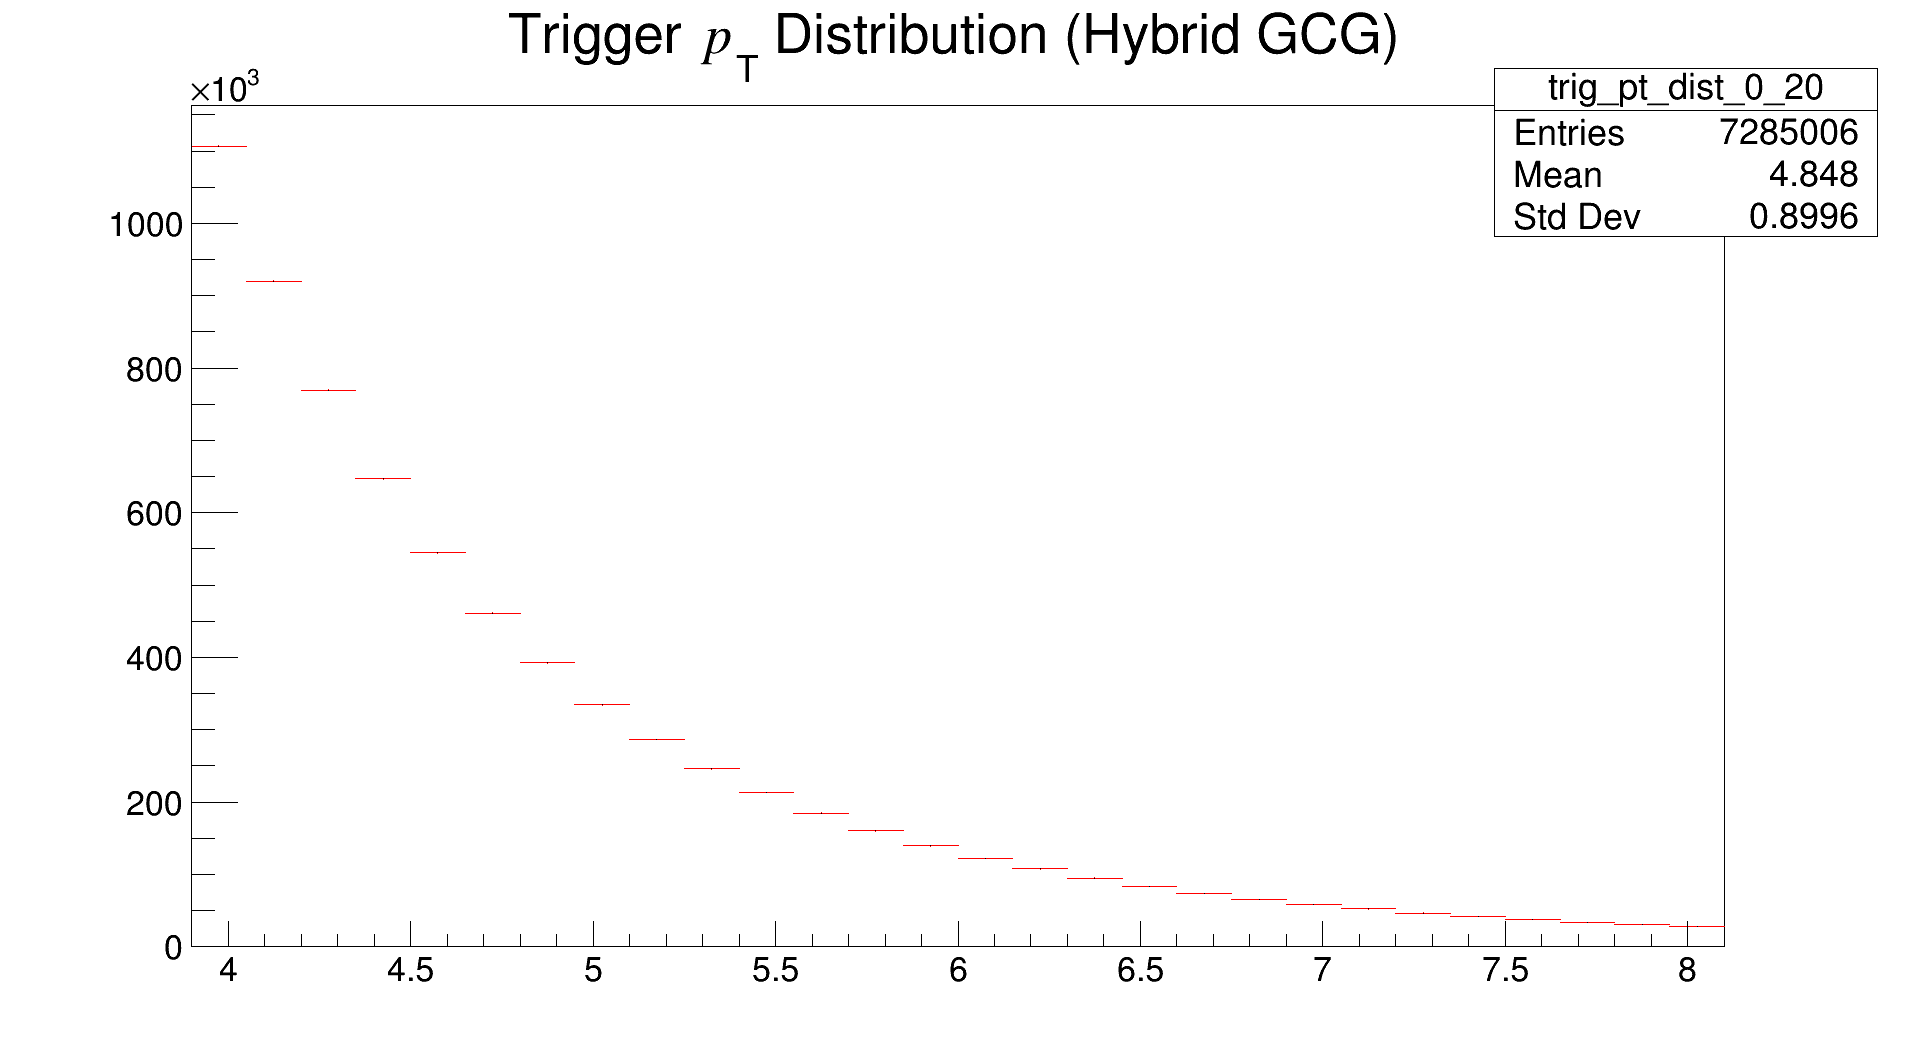

In [17]:
trig_pt_dist_0_20.Draw()
c.Draw()

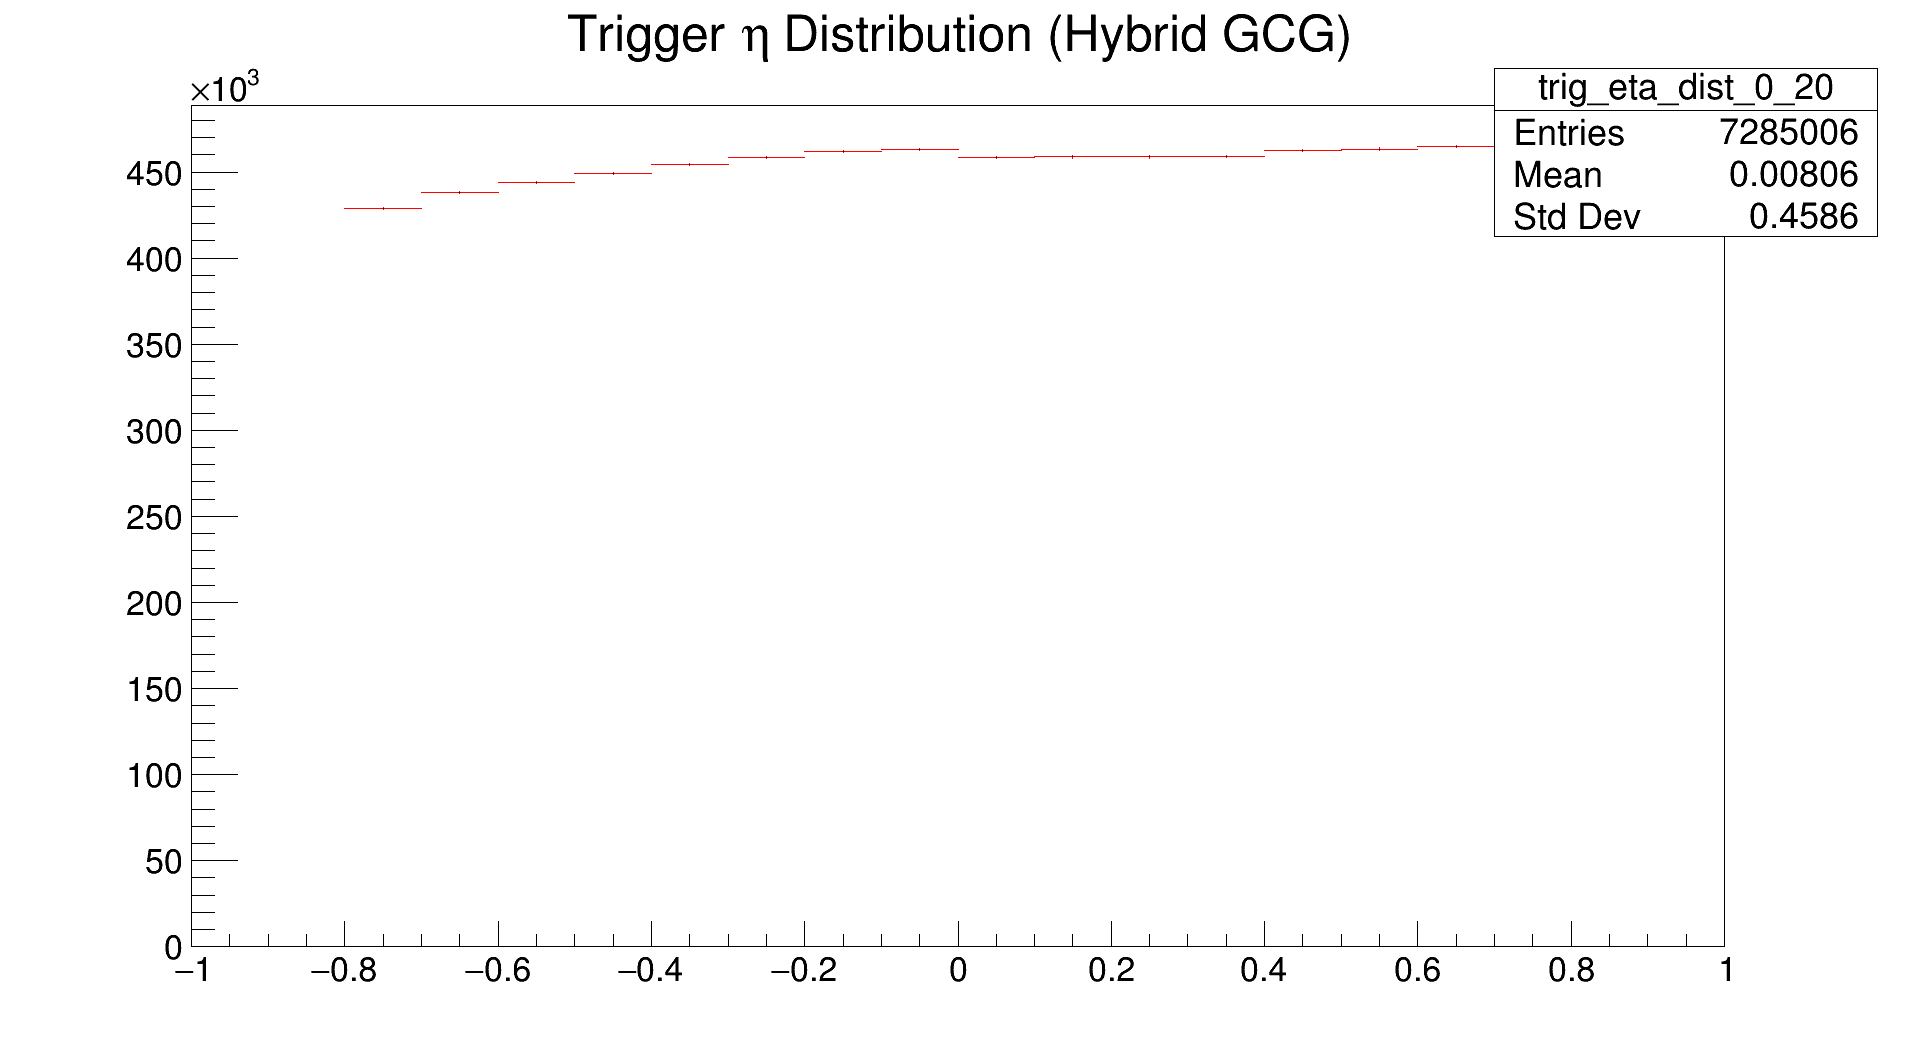

In [18]:
trig_eta_dist_0_20.Draw()
c.Draw()

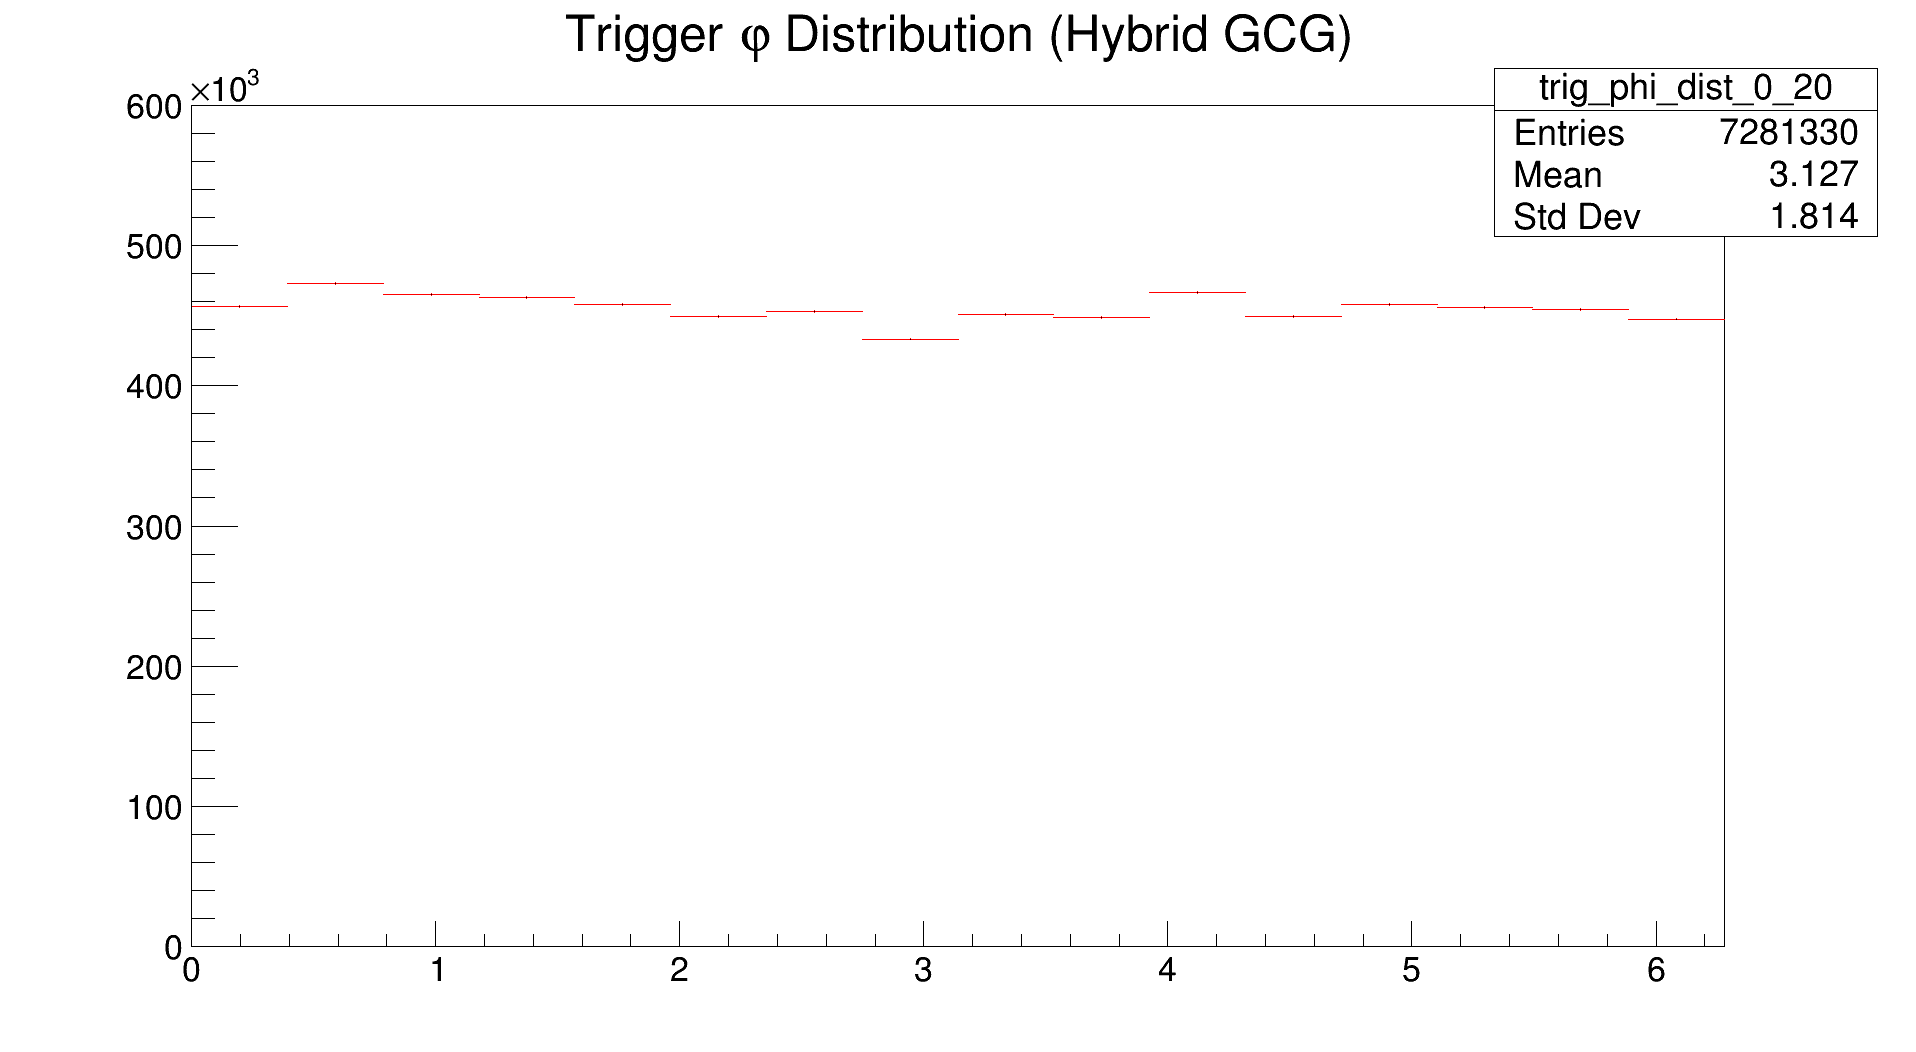

In [19]:
trig_phi_dist_0_20.GetYaxis().SetRangeUser(0, 600e3)
trig_phi_dist_0_20.Draw()
c.Draw()

### Signal analysis section

In [20]:
# eta cuts first
lambda_dist_0_20.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_mass_dist_0_20 = lambda_dist_0_20.Projection(3).Clone("lambda_mass_dist_0_20")

In [21]:
lambda_mass_dist_0_20.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist_0_20.Sumw2()
lambda_mass_dist_0_20.SetLineWidth(2)
lambda_mass_dist_0_20.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist_0_20.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

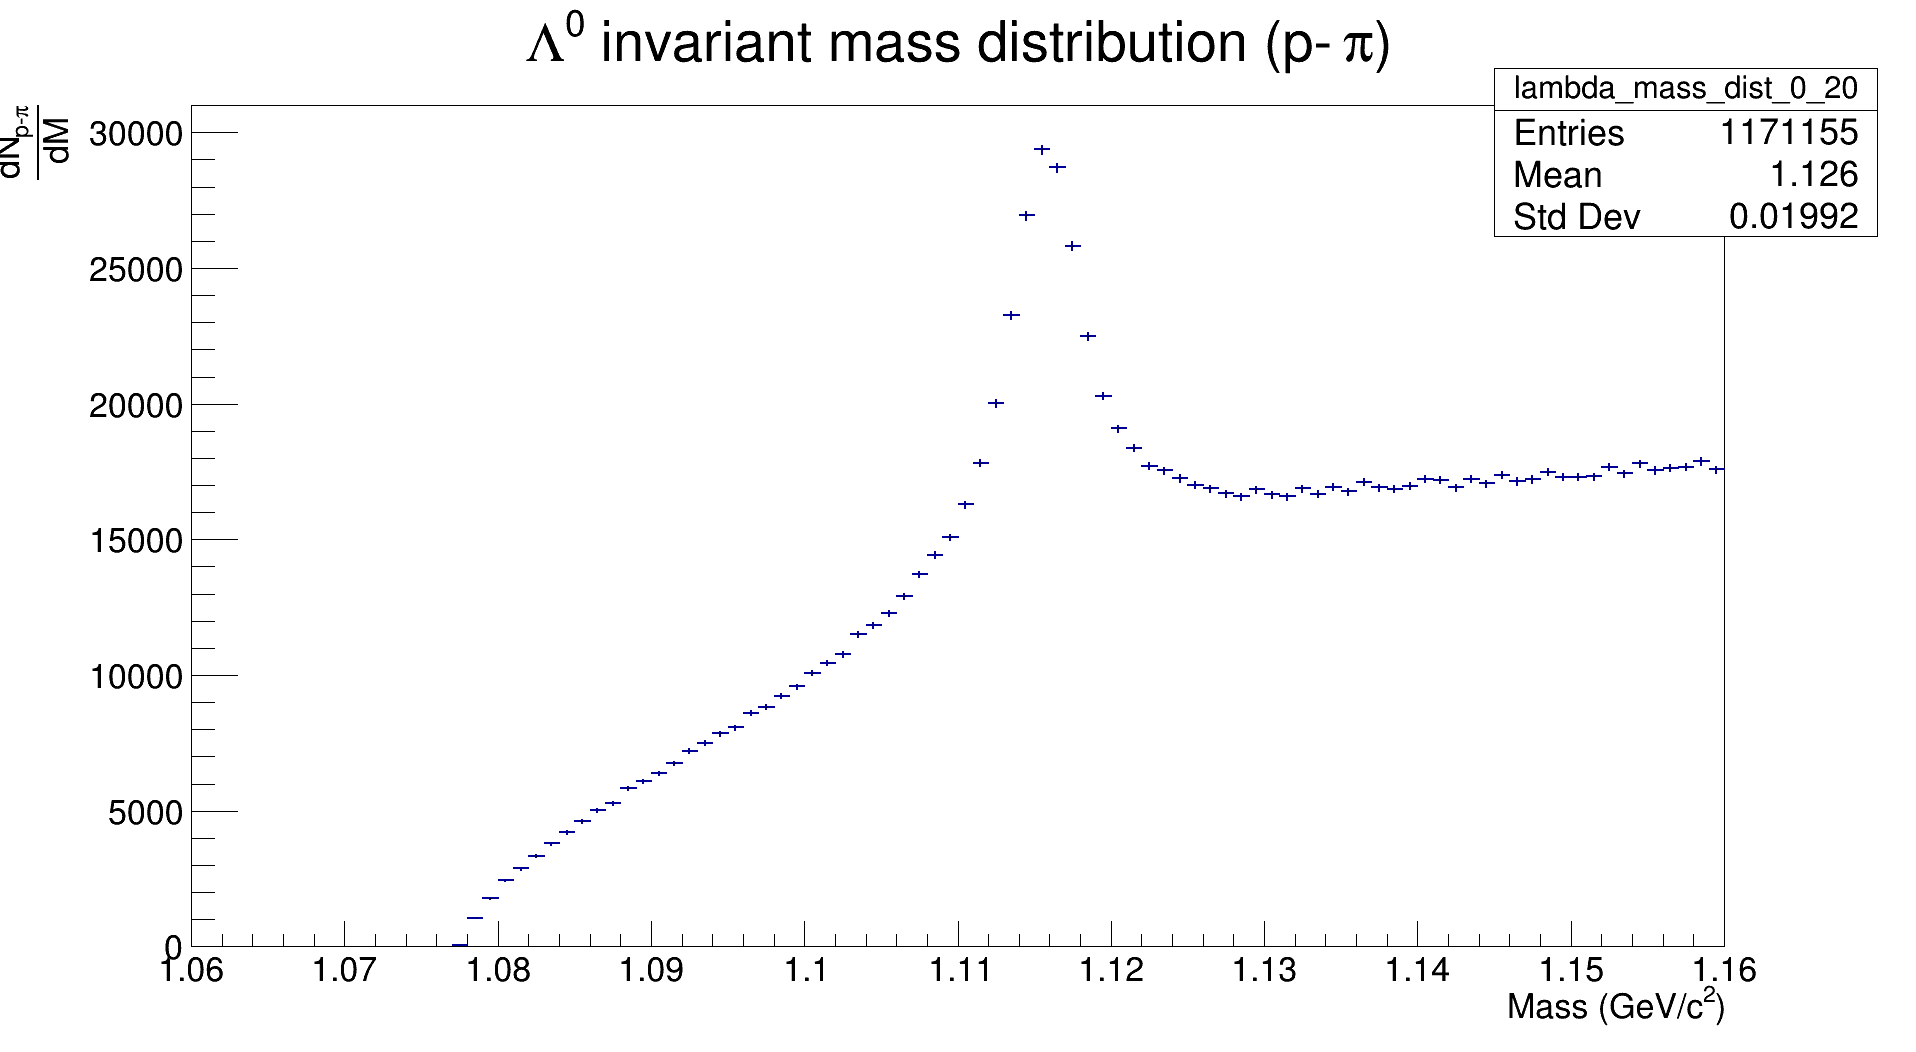

In [22]:
lambda_mass_dist_0_20.Draw()
c.Draw()

In [23]:
bin_1 = lambda_mass_dist_0_20.FindBin(1.09)
bin_2 = lambda_mass_dist_0_20.FindBin(1.15)
bin_3 = lambda_mass_dist_0_20.FindBin(1.16 - EPSILON)
point_one = [1.09, lambda_mass_dist_0_20.GetBinContent(bin_1)]
point_two = [1.15, lambda_mass_dist_0_20.GetBinContent(bin_2)]
point_three = [1.16, lambda_mass_dist_0_20.GetBinContent(bin_3)]
bg_starting_params_0_20 = get_parabola(point_one, point_two, point_three)

In [24]:
lambda_mass_fit_0_20.Delete()

NameError: name 'lambda_mass_fit_0_20' is not defined

In [25]:
lambda_mass_fit_0_20 = rt.TF1("lambda_mass_fit_0_20", "[0]*TMath::Voigt(x - [1], [2], [3], 4) + pol2(4)", 1.09, 1.155)
lambda_mass_fit_0_20.SetNpx(1000)
lambda_mass_fit_0_20.SetParameter(0, 1.36753e01)
lambda_mass_fit_0_20.FixParameter(1, 1.11581)
lambda_mass_fit_0_20.SetParameter(2, 1.00576e-05 )
lambda_mass_fit_0_20.SetParameter(3, 6.04166e-03)
lambda_mass_fit_0_20.SetParameter(4, bg_starting_params_0_20[0])
lambda_mass_fit_0_20.SetParameter(5, bg_starting_params_0_20[1])
lambda_mass_fit_0_20.SetParameter(6, bg_starting_params_0_20[2])

 FCN=139.483 FROM MIGRAD    STATUS=FAILED        555 CALLS         556 TOTAL
                     EDM=0.000882816    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.52351e+02   1.57968e+00  -0.00000e+00   1.68948e-03
   2  p1           1.11581e+00     fixed    
   3  p2           8.51282e-06   1.16787e-10   0.00000e+00  -3.63728e+08
   4  p3           6.11990e-03   7.25274e-05  -0.00000e+00  -3.69702e+01
   5  p4          -4.09577e+06   8.13773e+04   0.00000e+00   8.25386e-05
   6  p5           7.15055e+06   1.45422e+05  -0.00000e+00   9.33628e-05
   7  p6          -3.10784e+06   6.49393e+04   0.00000e+00   1.05661e-04


Warning in <Fit>: Abnormal termination of minimization.


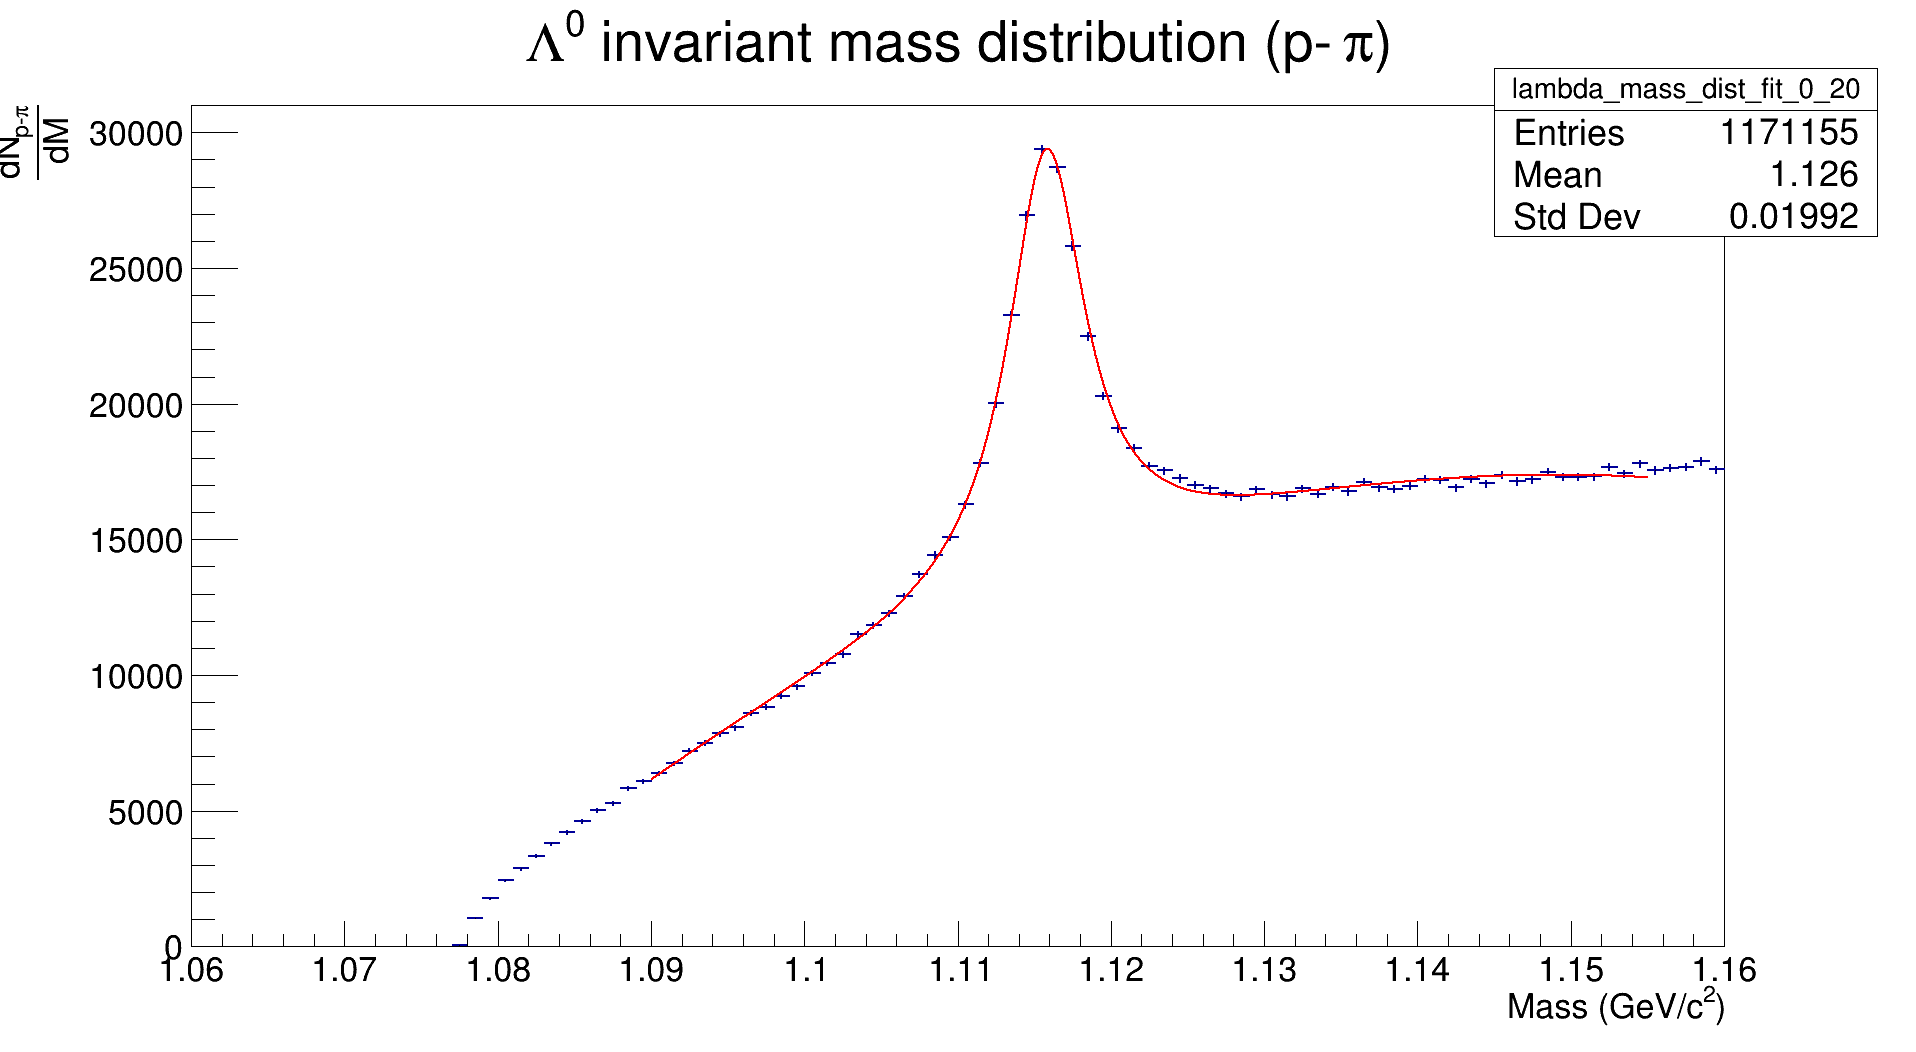

In [26]:
lambda_mass_dist_fit_0_20 = lambda_mass_dist_0_20.Clone("lambda_mass_dist_fit_0_20")
lambda_mass_dist_fit_0_20.Fit(lambda_mass_fit_0_20, "RS")
lambda_mass_dist_fit_0_20.Draw()
c.Draw()

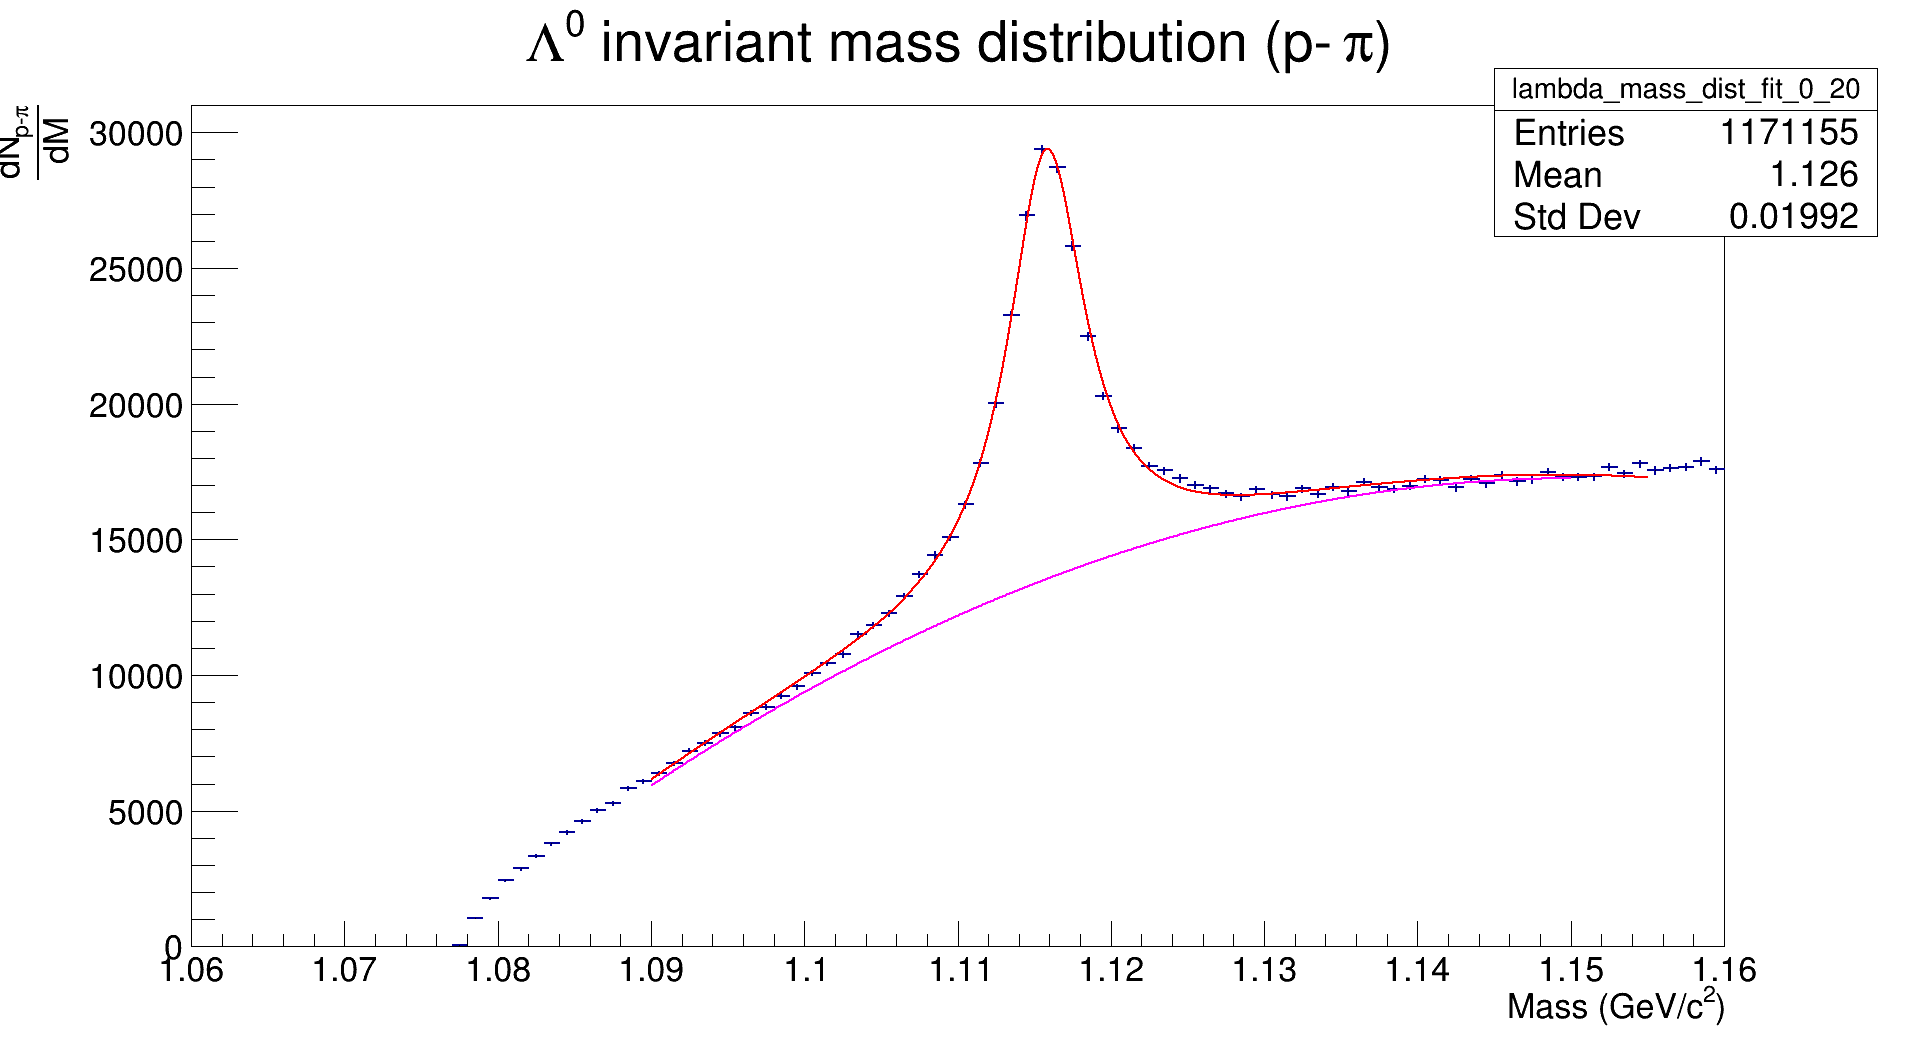

In [27]:
bg_fit_0_20 = rt.TF1("bg_fit_0_20", "pol2", 1.09, 1.15)
bg_fit_0_20.SetParameter(0, lambda_mass_fit_0_20.GetParameter(4))
bg_fit_0_20.SetParameter(1, lambda_mass_fit_0_20.GetParameter(5))
bg_fit_0_20.SetParameter(2, lambda_mass_fit_0_20.GetParameter(6))
bg_fit_0_20.SetNpx(1000)
bg_fit_0_20.SetLineColor(rt.kMagenta)
lambda_mass_dist_fit_0_20.Draw()
bg_fit_0_20.Draw("SAME")
c.Draw()

In [28]:
left_signal_bin_0_20 = lambda_mass_dist_fit_0_20.FindBin(SIG_MIN)
right_signal_bin_0_20 = lambda_mass_dist_fit_0_20.FindBin(SIG_MAX)

lambda_bg_0_20 = 0
lambda_total_0_20 = 0
for bin_num in range(left_signal_bin_0_20, right_signal_bin_0_20 + 1):
    bin_center = lambda_mass_dist_fit_0_20.GetBinCenter(bin_num)
    lambda_bg_0_20 += bg_fit_0_20.Eval(bin_center)
    lambda_total_0_20 += lambda_mass_dist_fit_0_20.GetBinContent(bin_num)

lambda_signal_0_20 = lambda_total_0_20 - lambda_bg_0_20
lambda_signal_total_ratio_0_20 = lambda_signal_0_20/lambda_total_0_20
lambda_signal_bg_ratio_0_20 = lambda_signal_0_20/lambda_bg_0_20
print(f"The 0-20 lambda signal is: {lambda_signal_0_20}")
print(f"The 0-20 lambda background is: {lambda_bg_0_20}")
print(f"The 0-20 lambda S/B is: {lambda_signal_bg_ratio_0_20}")
print(f"The 0-20 lambda S/T is: {lambda_signal_total_ratio_0_20}")
print(f"The 0-20 lambda significance is: {lambda_signal_0_20/math.sqrt(lambda_signal_0_20 + lambda_bg_0_20)}")

The 0-20 lambda signal is: 117047.85524103418
The 0-20 lambda background is: 216224.14475896582
The 0-20 lambda S/B is: 0.5413264803128826
The 0-20 lambda S/T is: 0.3512081880297
The 0-20 lambda significance is: 202.75148618929094


### Mixed event correction section

In [29]:
axes = arr.array('i', [2, 3, 4, 5])
h_lambda_0_20 = h_lambda_0_20.Projection(4, axes)
h_lambda_ls_0_20 = h_lambda_ls_0_20.Projection(4, axes)
h_lambda_mixed_0_20 = h_lambda_mixed_0_20.Projection(4, axes)
h_lambda_ls_mixed_0_20 = h_lambda_ls_mixed_0_20.Projection(4, axes)

In [30]:
h_h_0_20 = h_h_0_20.Projection(2, 3, 4)
h_h_mixed_0_20 = h_h_mixed_0_20.Projection(2, 3, 4)
h_h_0_20.Sumw2()
h_h_mixed_0_20.Sumw2()

In [31]:
# Setting up 2-d correlation plots before the mixed event correction
h_lambda_2d_nomixcor_0_20 = h_lambda_0_20.Projection(0, 1).Clone("h_lambda_2d_nomixcor_0_20")
h_lambda_ls_2d_nomixcor_0_20 = h_lambda_ls_0_20.Projection(0, 1).Clone("h_lambda_ls_2d_nomixcor_0_20")
h_lambda_mixed_2d_0_20 = h_lambda_mixed_0_20.Projection(0, 1).Clone("h_lambda_mixed_2d_0_20")

In [32]:
h_h_2d_nomixcor_0_20 = h_h_0_20.Project3D("xye").Clone("h_h_2d_nomixcor_0_20")
h_h_mixed_2d_0_20 = h_h_mixed_0_20.Project3D("xye").Clone("h_h_mixed_2d_0_20")

In [33]:
h_lambda_2d_nomixcor_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_0_20.SetTitle("h-#Lambda^{0} (LS) #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_ls_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_0_20.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta")
h_lambda_mixed_2d_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20.GetYaxis().SetTitleOffset(1.3)

In [34]:
h_h_2d_nomixcor_0_20.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction)")
h_h_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)
h_h_mixed_2d_0_20.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_0_20.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20.GetYaxis().SetTitleOffset(1.3)

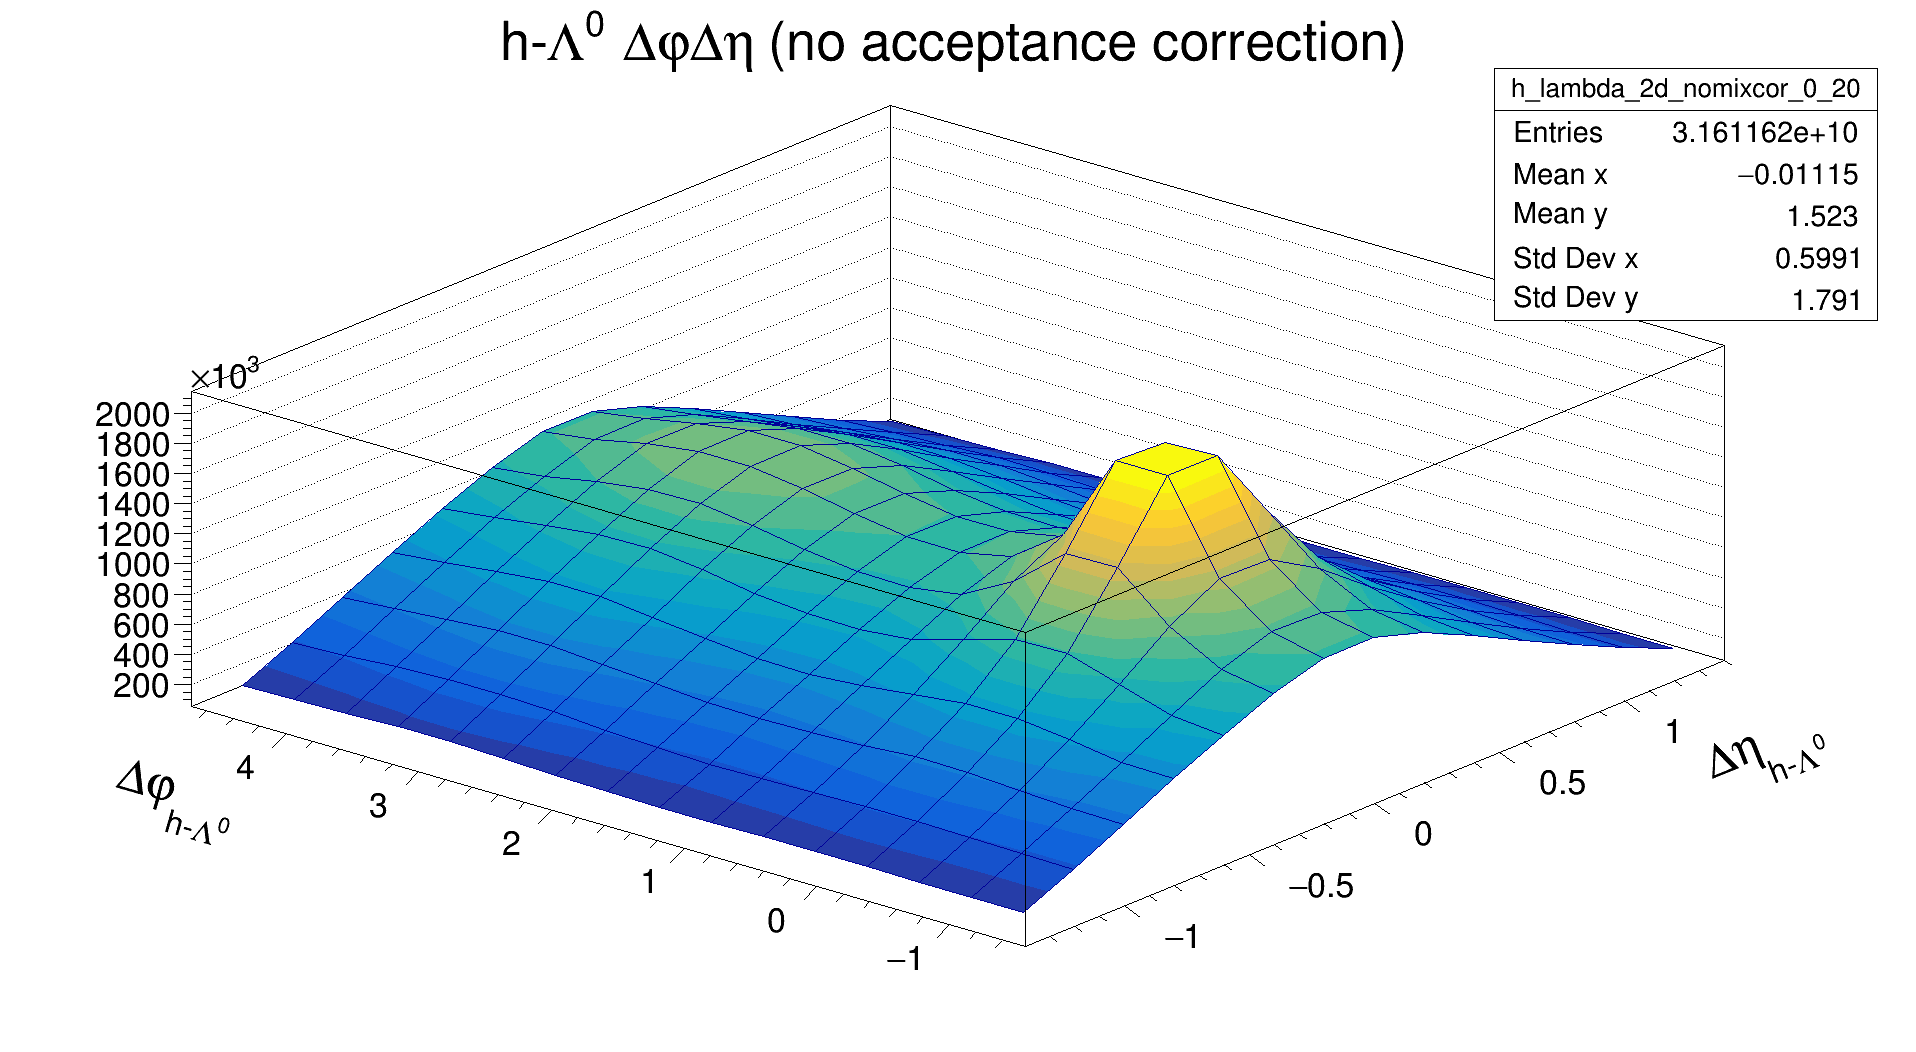

In [35]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

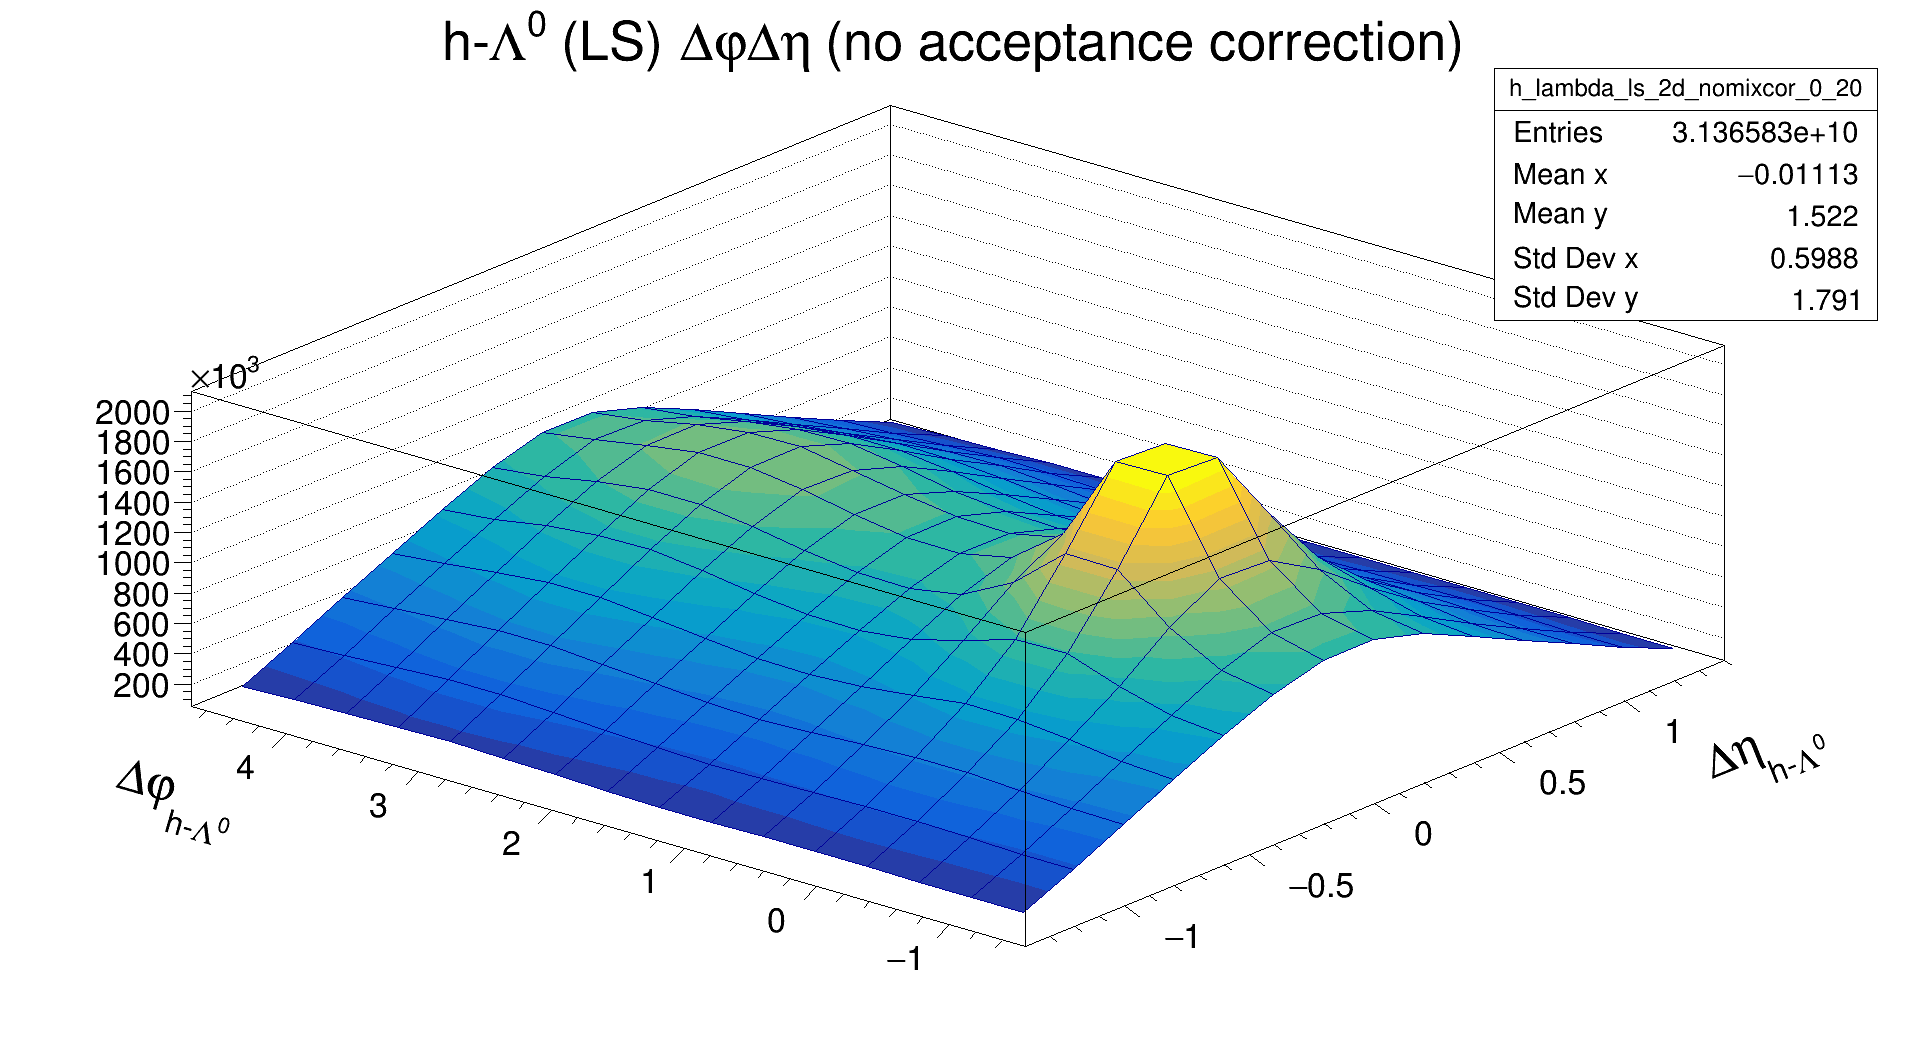

In [36]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_ls_2d_nomixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_ls_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

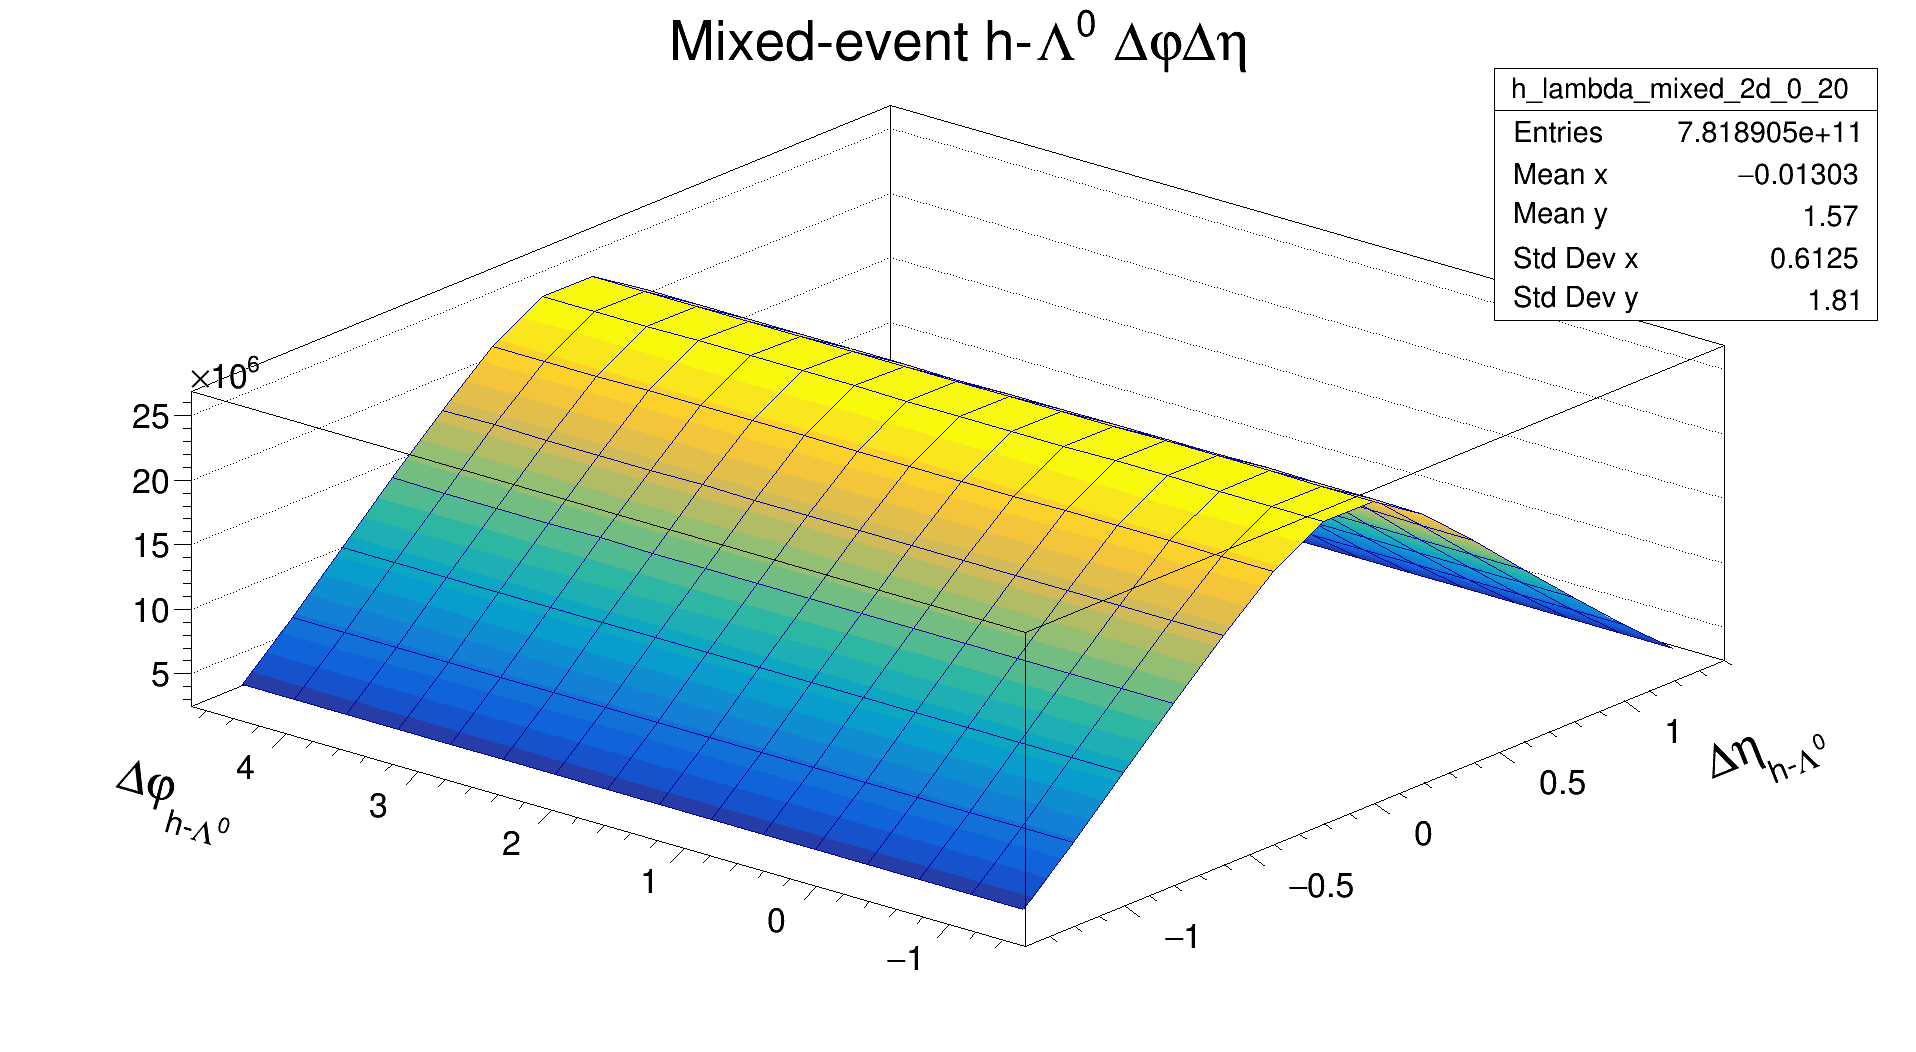

In [37]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_mixed_2d_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_mixed_2d_0_20.Draw("SURF1")
c.Draw()

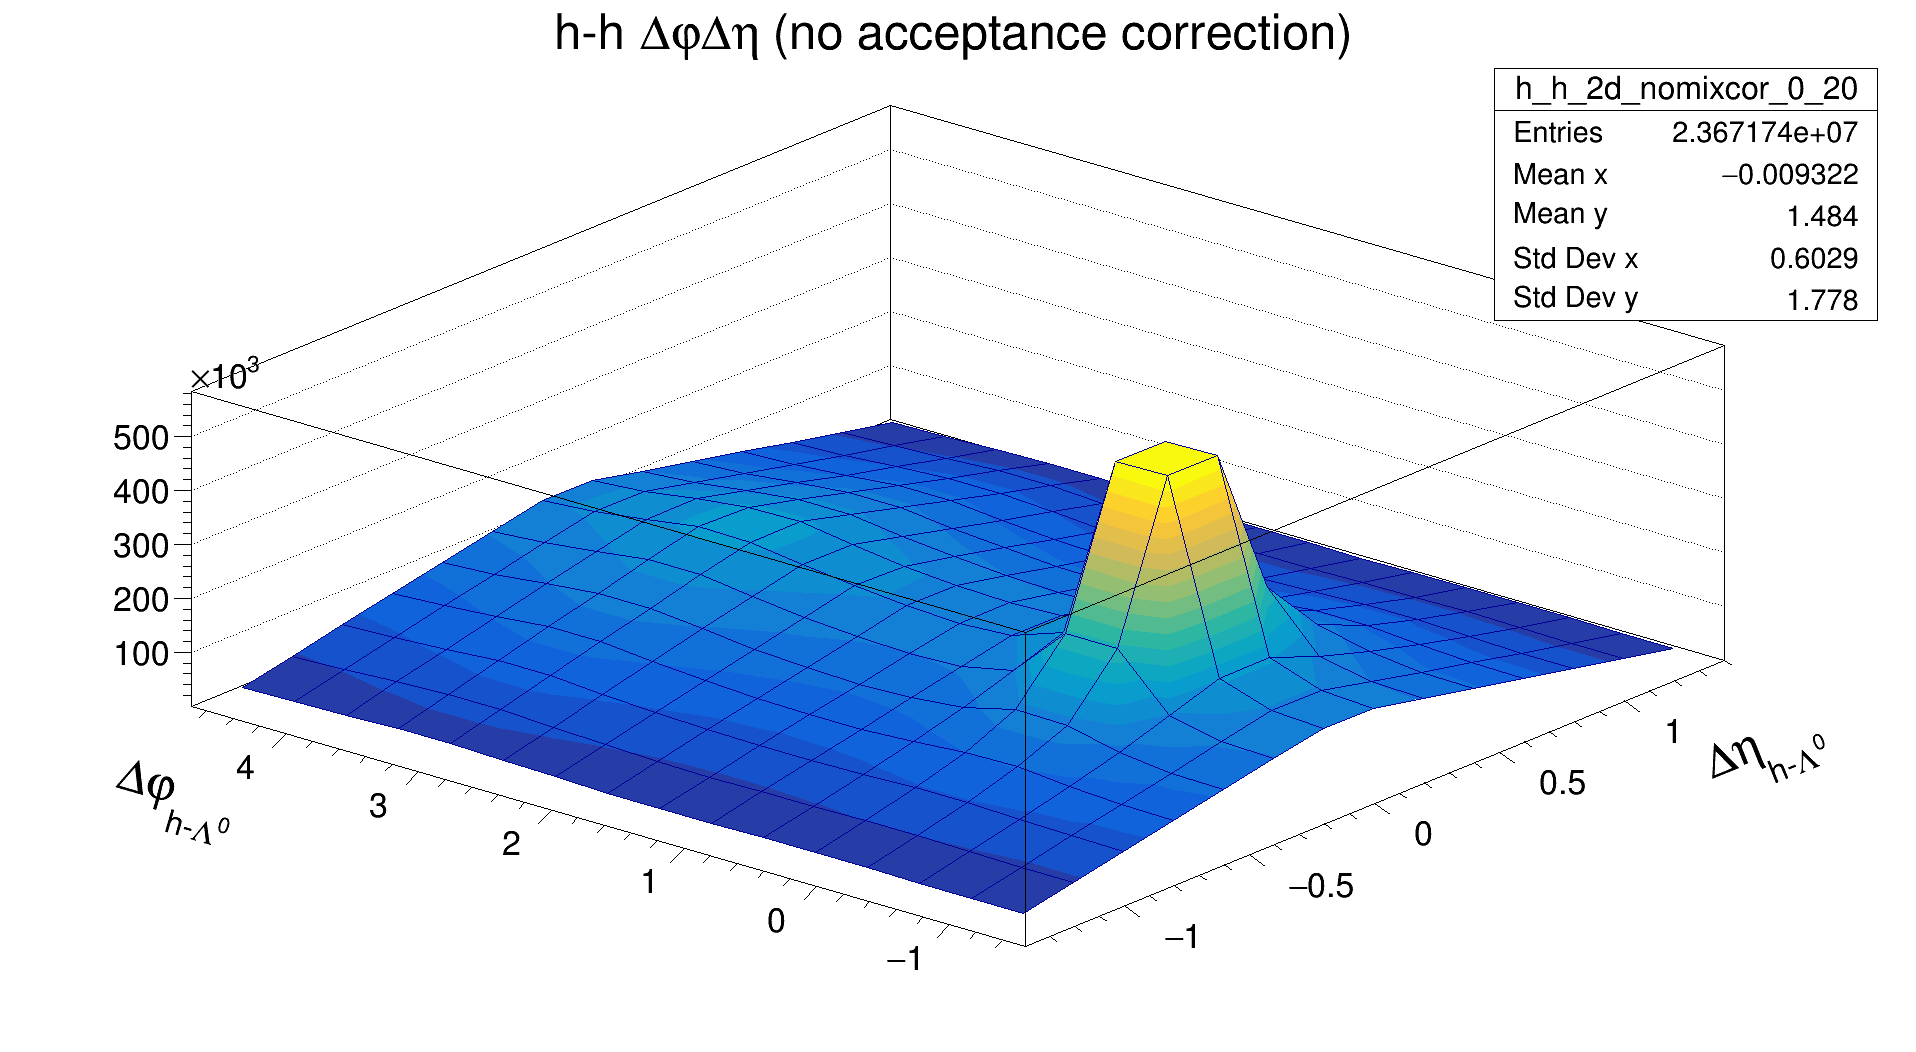

In [38]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_nomixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

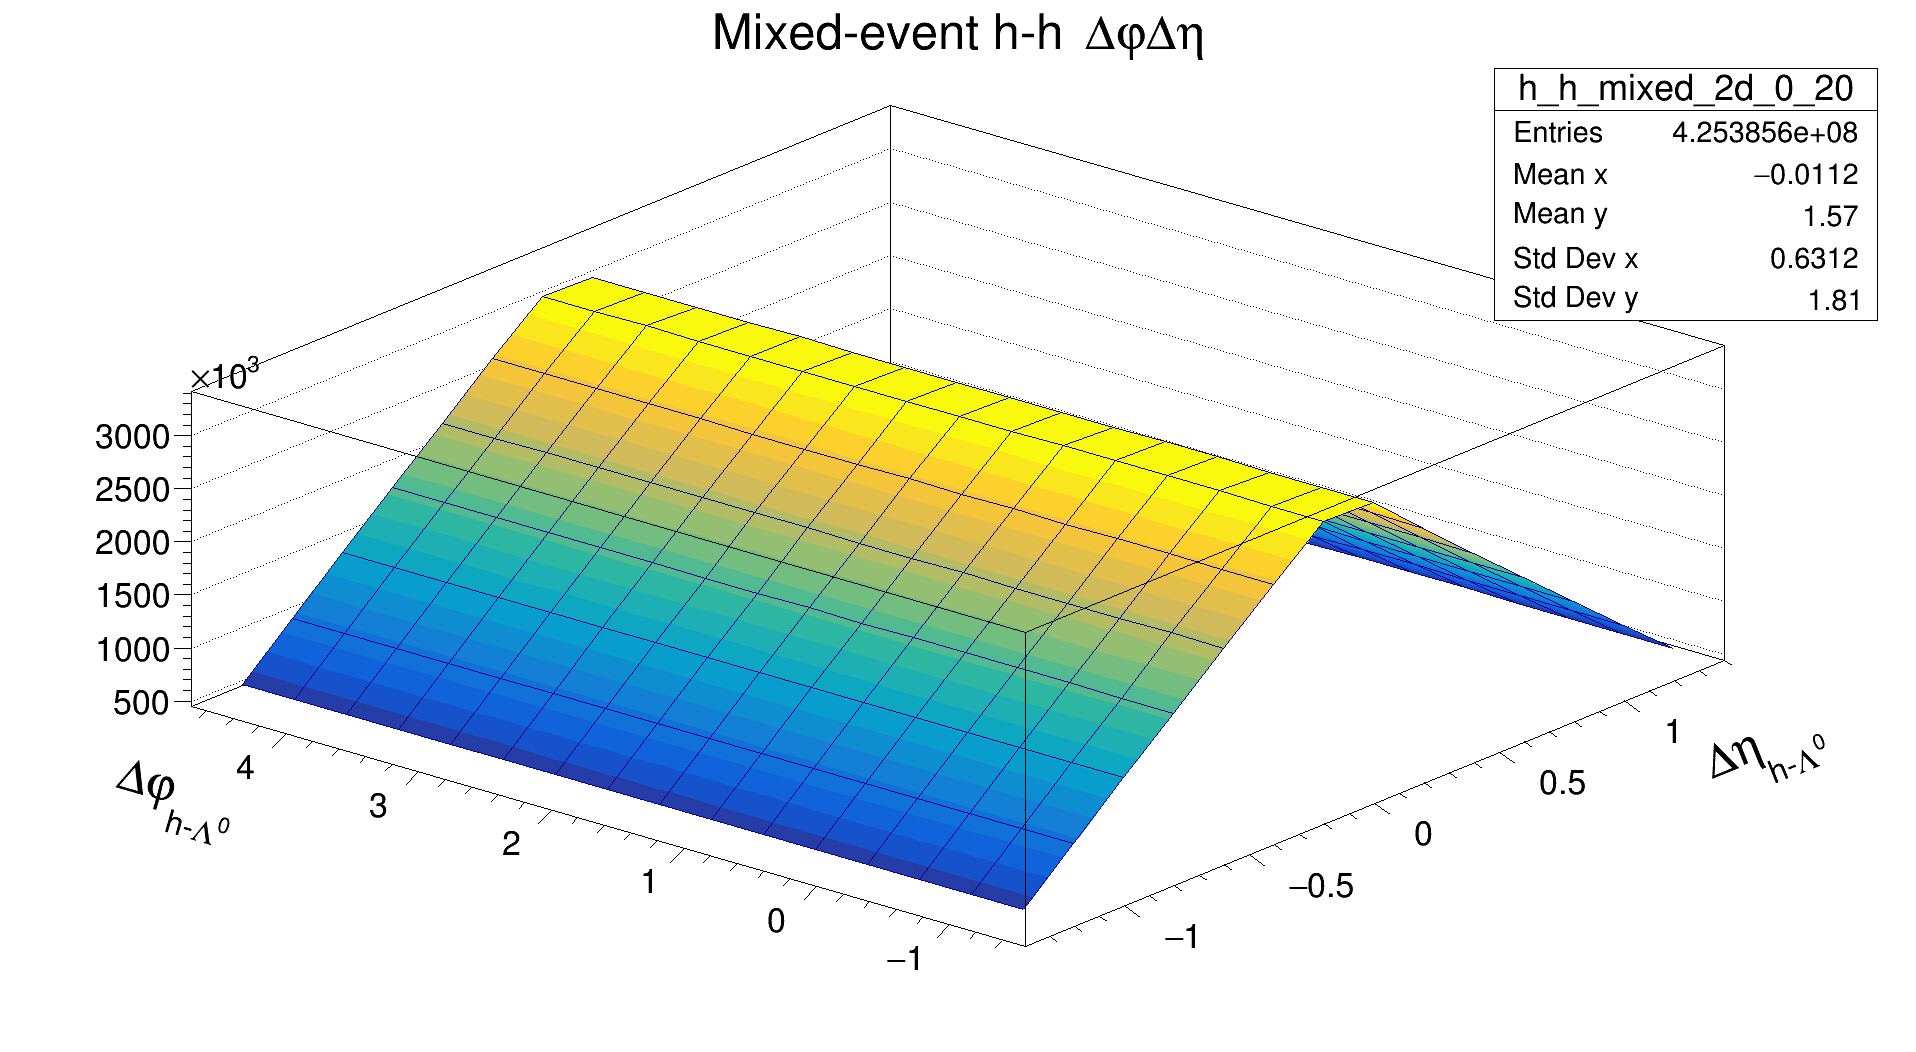

In [39]:
c.SetTheta(50)
c.SetPhi(50)
h_h_mixed_2d_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_mixed_2d_0_20.Draw("SURF1")
c.Draw()

In [40]:
h_lambda_2d_mixcor_lsb_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, LSB_MIN, LSB_MAX)
h_lambda_2d_mixcor_sig_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, RSB_MIN, RSB_MAX)
h_lambda_ls_2d_mixcor_lsb_0_20 = make_mixed_corrections(h_lambda_ls_0_20, h_lambda_ls_mixed_0_20, LSB_MIN, LSB_MAX)
h_lambda_ls_2d_mixcor_sig_0_20 = make_mixed_corrections(h_lambda_ls_0_20, h_lambda_ls_mixed_0_20, SIG_MIN, SIG_MAX)
h_lambda_ls_2d_mixcor_rsb_0_20 = make_mixed_corrections(h_lambda_ls_0_20, h_lambda_ls_mixed_0_20, RSB_MIN, RSB_MAX)

Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaEff_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaEff_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaLS_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaLSMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaLS_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaLSMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).


In [41]:
h_h_2d_mixcor_0_20 = make_mixed_corrections(h_h_0_20, h_h_mixed_0_20, LSB_MIN, LSB_MAX, is_hh=True)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [42]:
h_lambda_2d_mixcor_lsb_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (LSB, acceptance corrected)")
h_lambda_2d_mixcor_lsb_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_lsb_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_sig_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (SIG, acceptance corrected)")
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_rsb_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (RSB, acceptance corrected)")
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitleOffset(1.3)

In [43]:
h_h_2d_mixcor_0_20.SetTitle("h-h #Delta#varphi#Delta#eta correlation (acceptance corrected)")
h_h_2d_mixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_mixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_mixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_h_2d_mixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_2d_mixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_h_2d_mixcor_0_20.GetYaxis().SetTitleOffset(1.3)

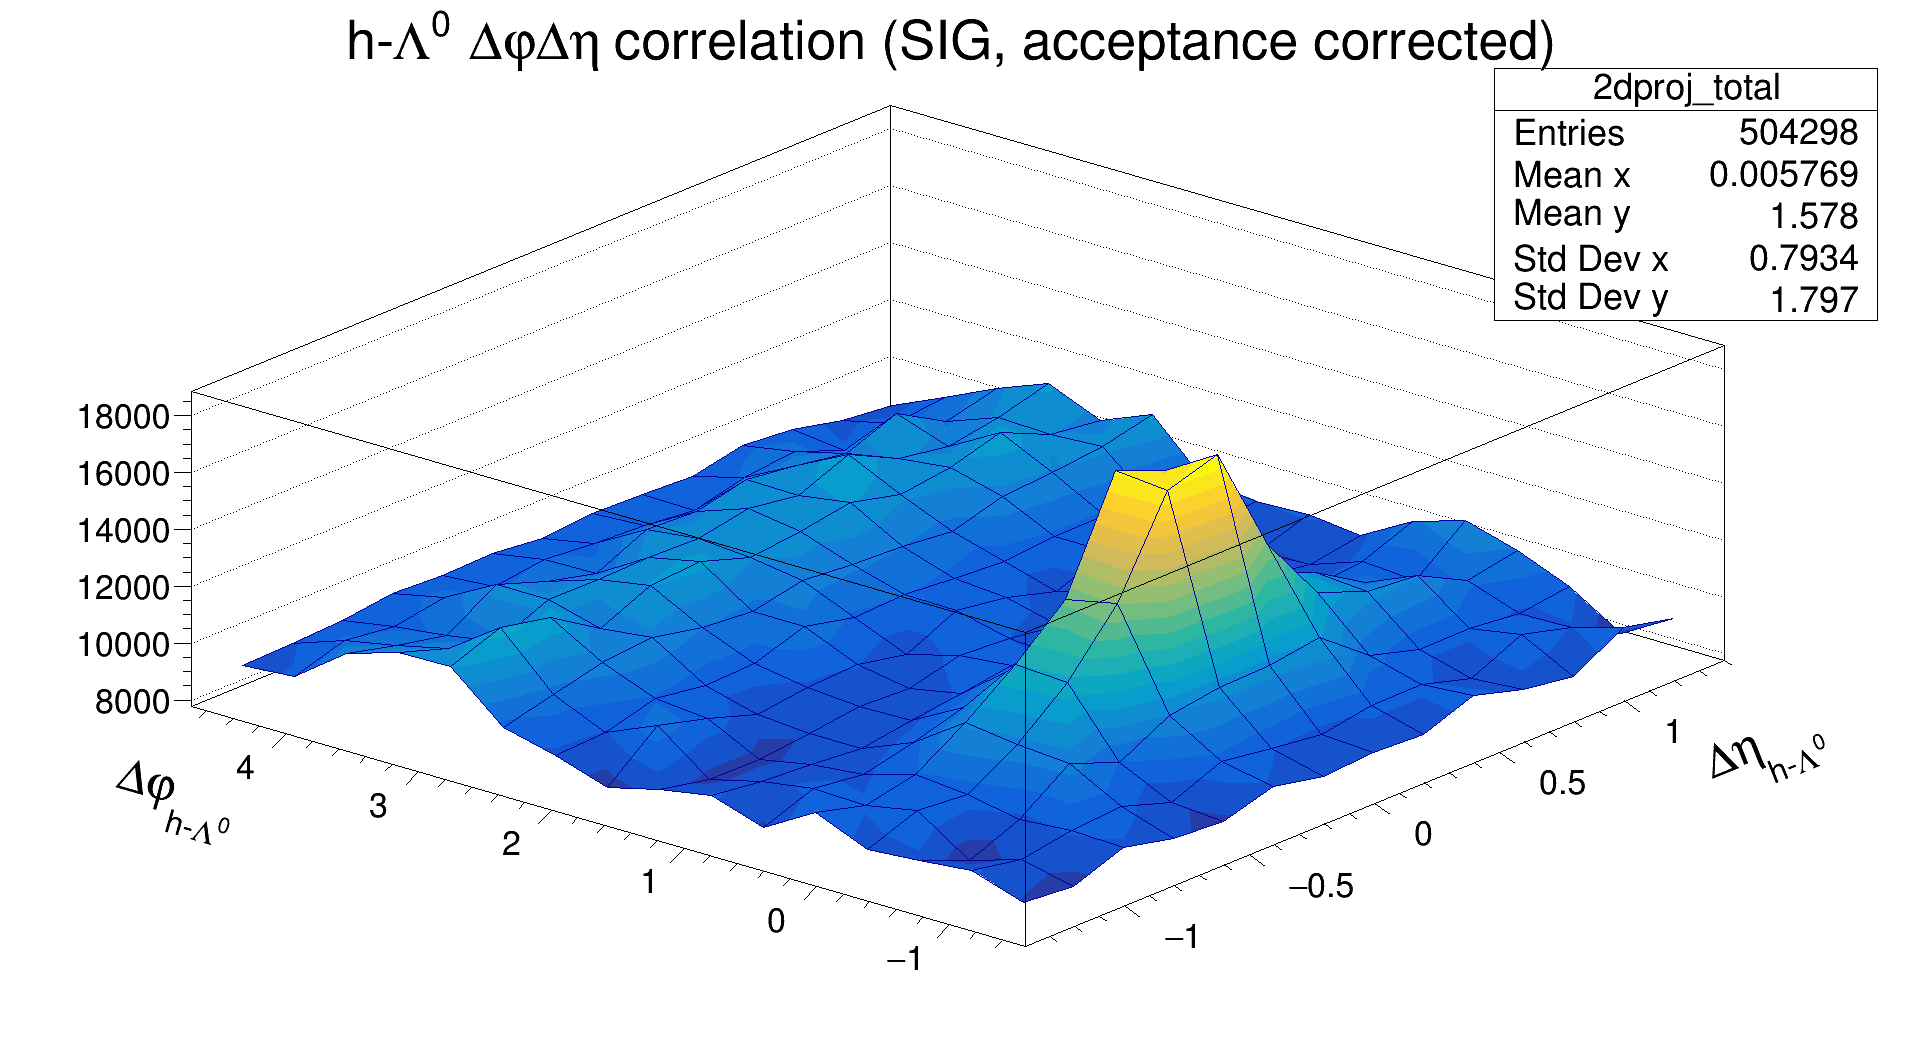

In [44]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig_0_20.Draw("SURF1")
c.Draw()

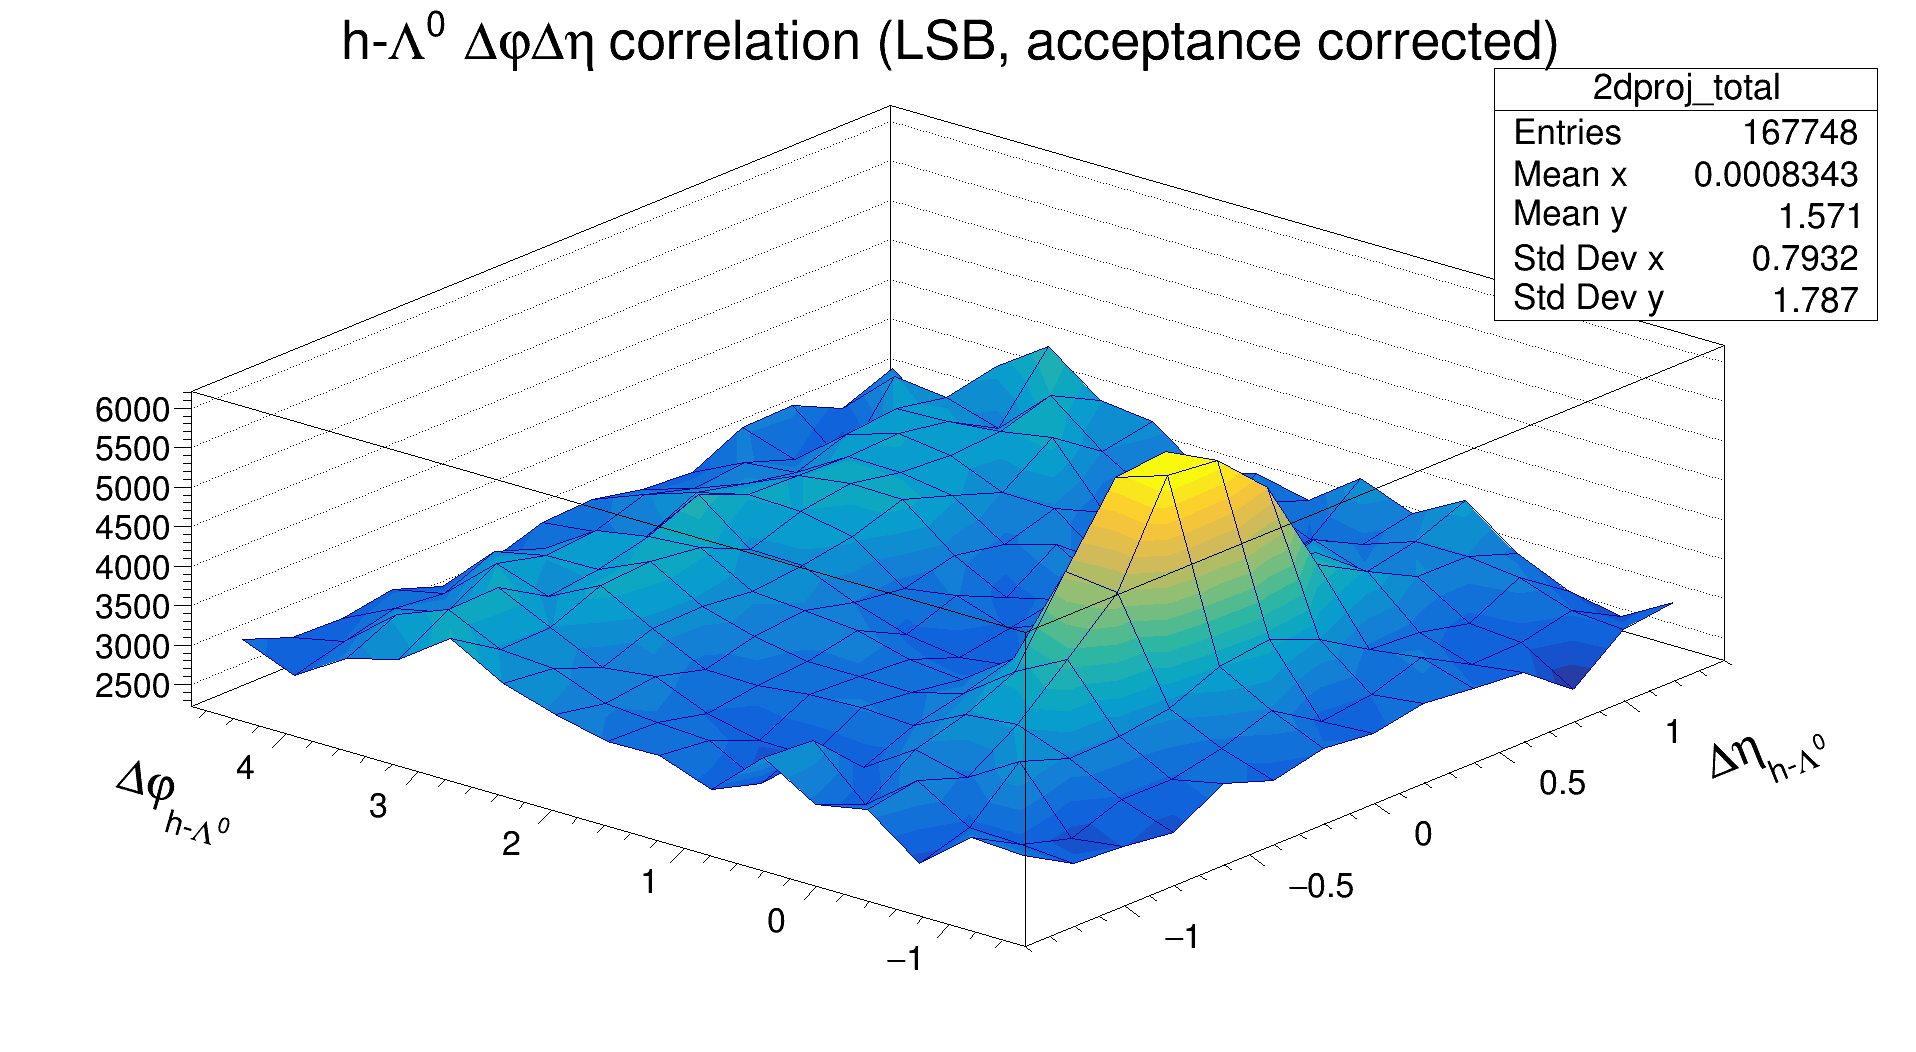

In [45]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_lsb_0_20.Draw("SURF1")
c.Draw()

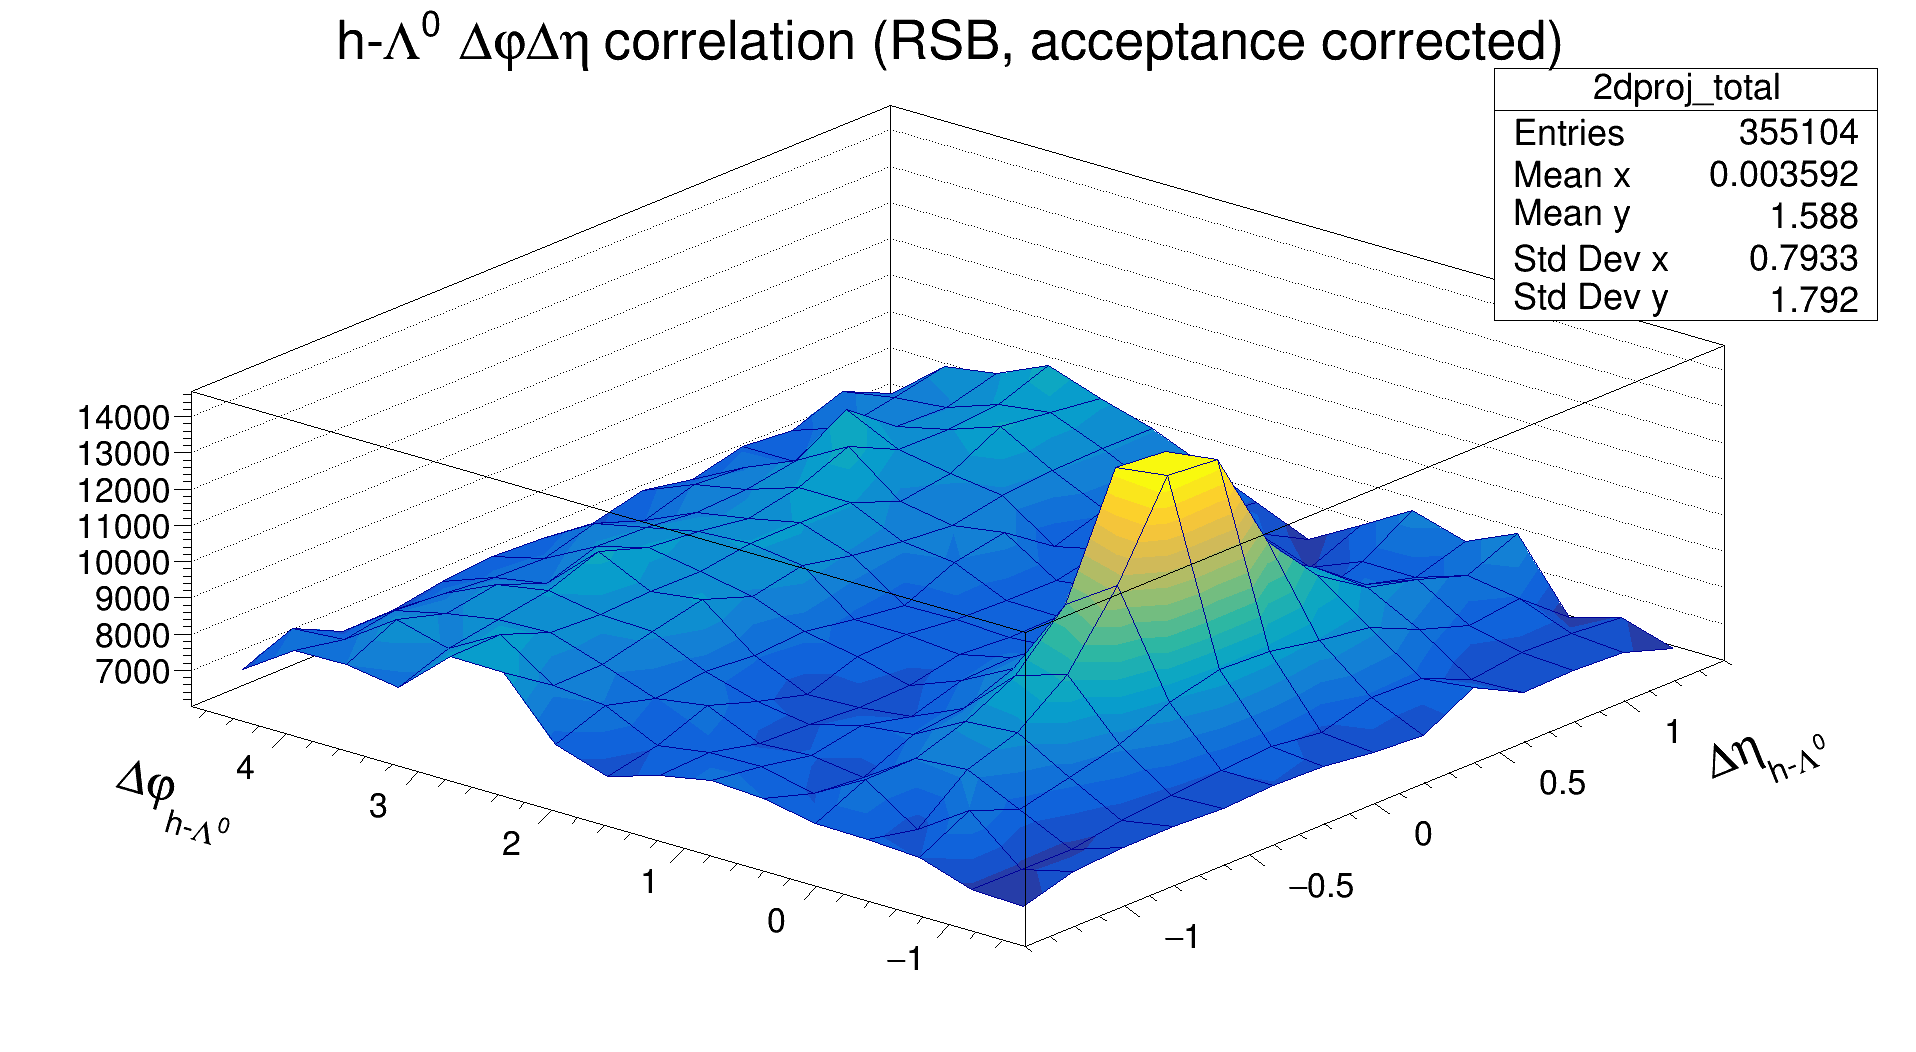

In [46]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb_0_20.Draw("SURF1")
c.Draw()

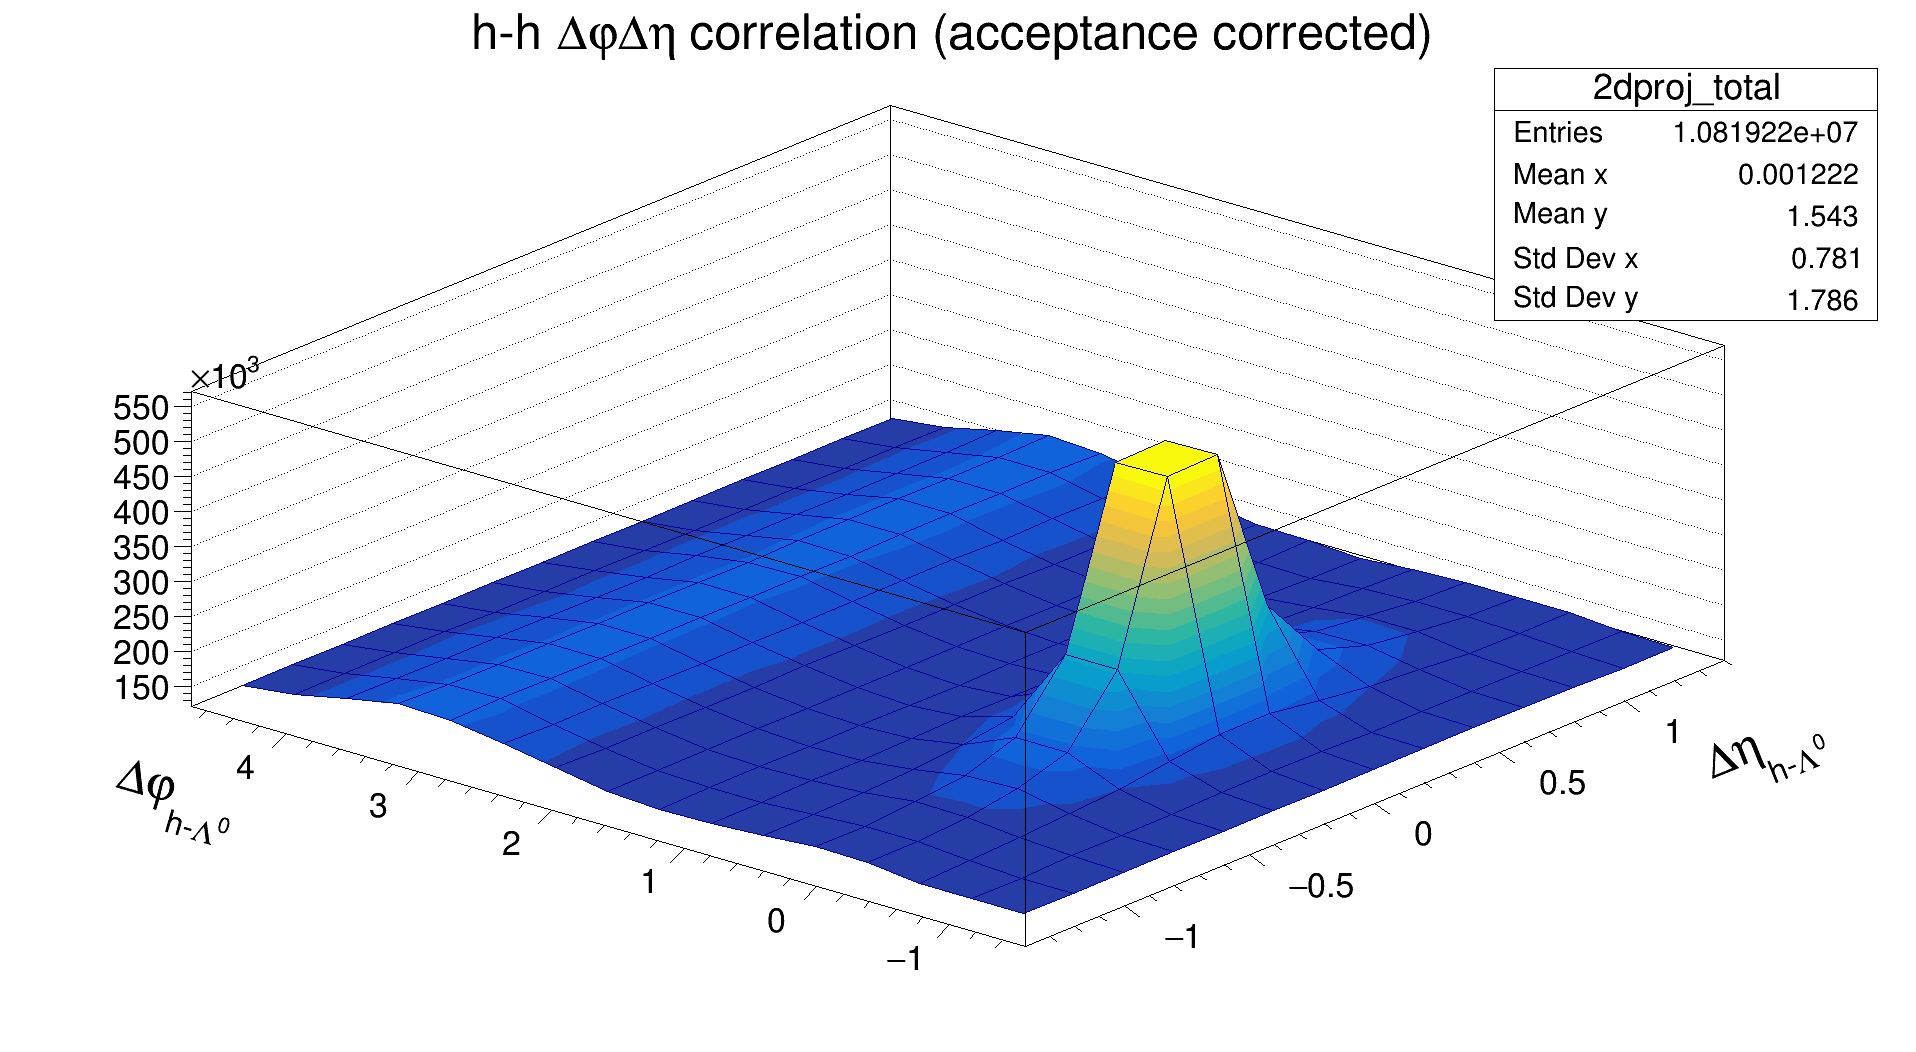

In [47]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_mixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_0_20.Draw("SURF1")
c.Draw()

In [48]:
# per-trigger normalization done here
h_lambda_2d_mixcor_lsb_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_sig_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_rsb_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_ls_2d_mixcor_lsb_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_ls_2d_mixcor_sig_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_ls_2d_mixcor_rsb_0_20.Scale(1.0/num_trigs_0_20)
h_h_2d_mixcor_0_20.Scale(1.0/num_trigs_0_20)

### Sideband subtraction section

In [49]:
# First comparing left and right sidebands
h_lambda_lsb_dphi_0_20 = h_lambda_2d_mixcor_lsb_0_20.ProjectionY("h_lambda_lsb_dphi_0_20")
h_lambda_rsb_dphi_0_20 = h_lambda_2d_mixcor_rsb_0_20.ProjectionY("h_lambda_rsb_dphi_0_20")
h_lambda_sig_dphi_0_20 = h_lambda_2d_mixcor_sig_0_20.ProjectionY("h_lambda_sig_dphi_0_20")
h_lambda_lsb_dphi_0_20.Scale(1/h_lambda_lsb_dphi_0_20.Integral())
h_lambda_rsb_dphi_0_20.Scale(1/h_lambda_rsb_dphi_0_20.Integral())
h_lambda_sig_dphi_0_20.Scale(1/h_lambda_sig_dphi_0_20.Integral())

In [50]:
h_lambda_lsb_dphi_0_20.SetTitle("h-#Lambda^{0} LSB (blue) vs RSB (red) comparison (normalized to 1)")
h_lambda_lsb_dphi_0_20.SetLineColor(rt.kBlue)
h_lambda_rsb_dphi_0_20.SetLineColor(rt.kRed)
h_lambda_sig_dphi_0_20.SetLineColor(rt.kGreen + 2)
h_lambda_lsb_dphi_0_20.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_lsb_dphi_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_lsb_dphi_0_20.GetXaxis().SetTitleOffset(0.5)
h_lambda_lsb_dphi_0_20.SetStats(0)
h_lambda_rsb_dphi_0_20.SetStats(0)
h_lambda_sig_dphi_0_20.SetStats(0)

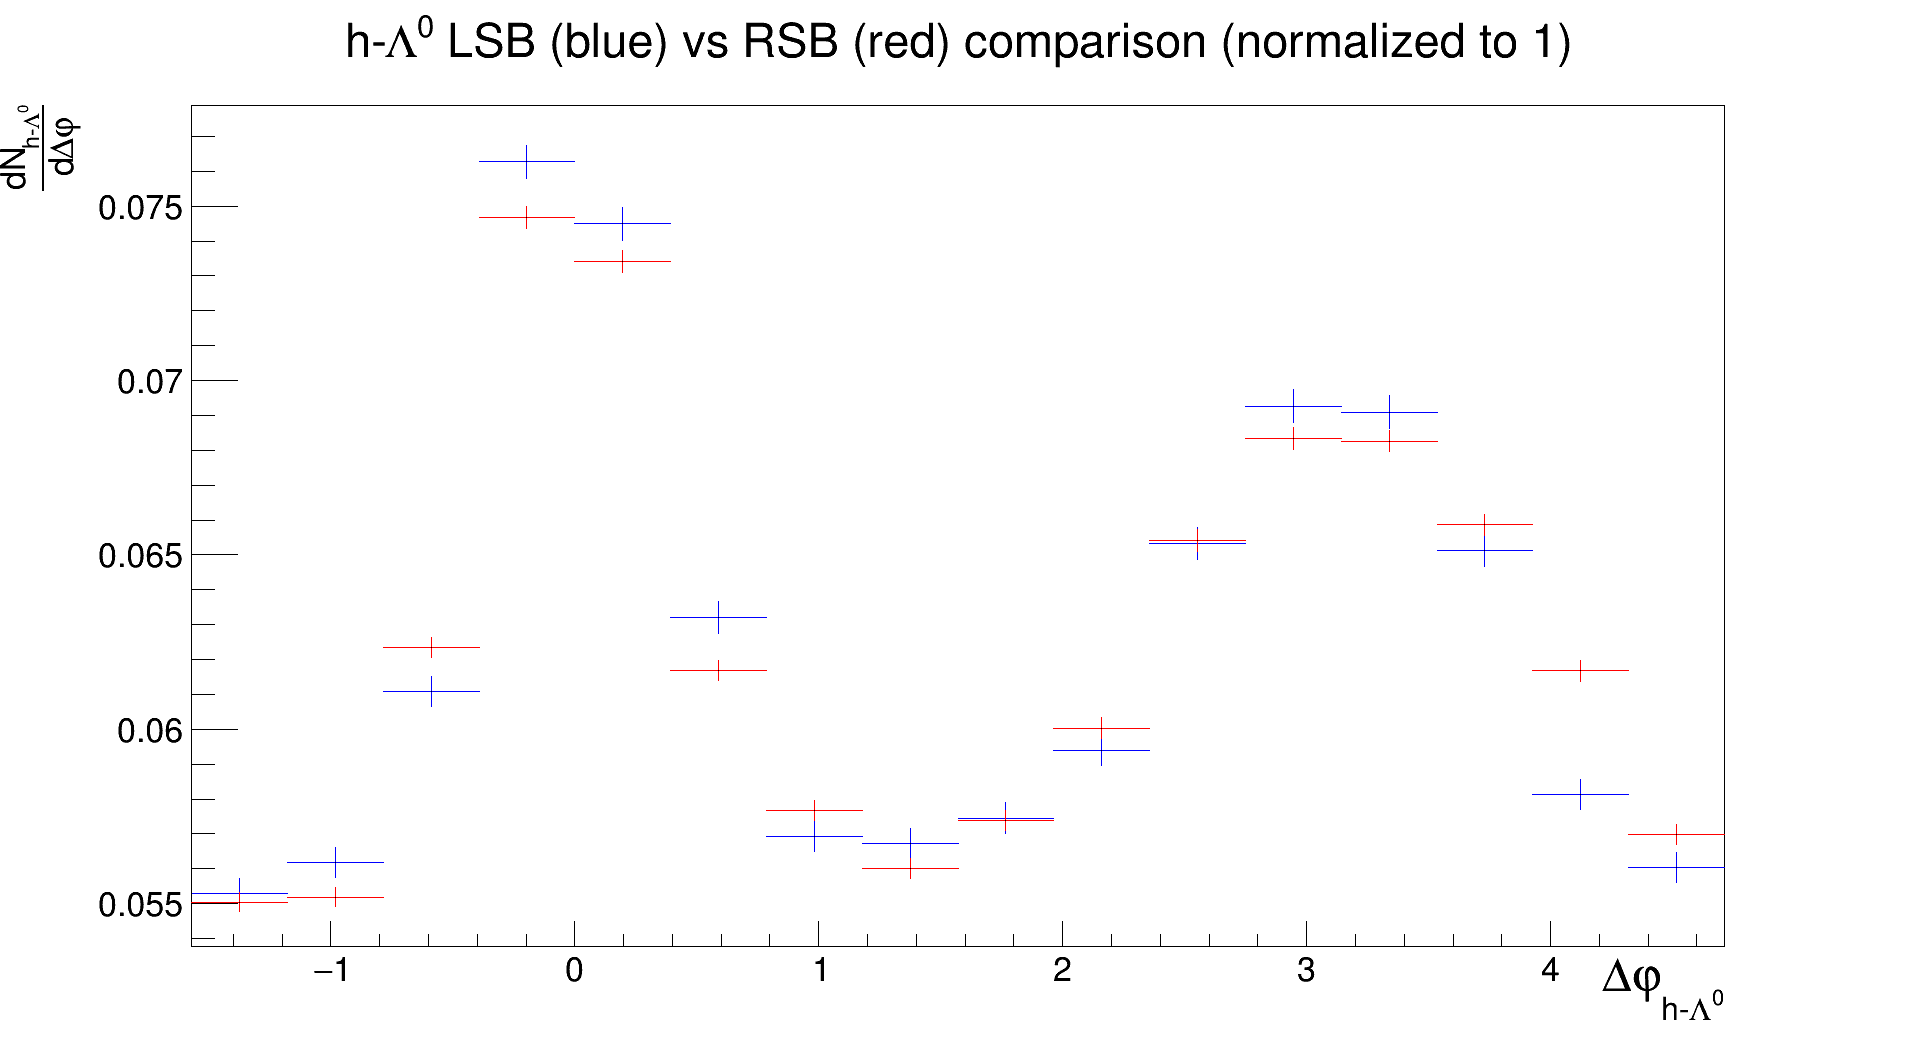

In [51]:
h_lambda_lsb_dphi_0_20.Draw()
h_lambda_rsb_dphi_0_20.Draw("SAME")
c.Draw()

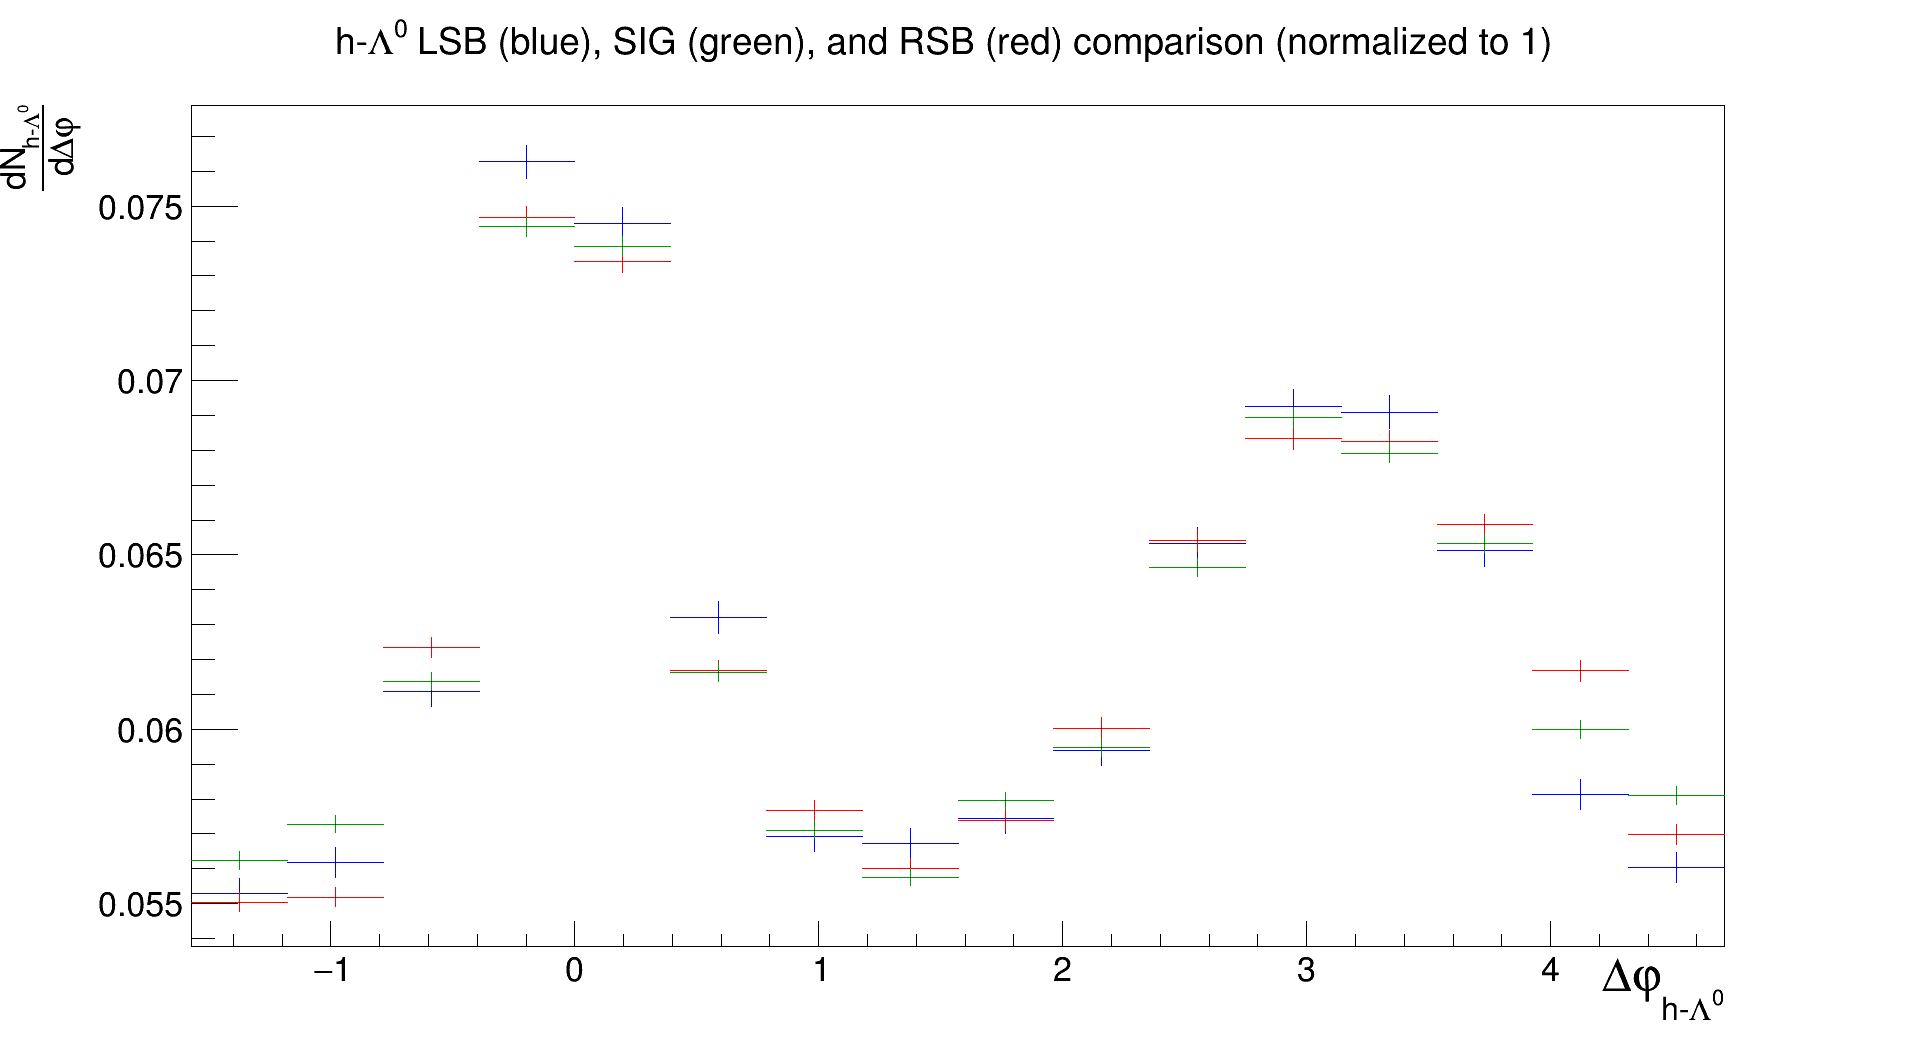

In [52]:
h_lambda_lsb_dphi_0_20.SetTitle("h-#Lambda^{0} LSB (blue), SIG (green), and RSB (red) comparison (normalized to 1)")
h_lambda_lsb_dphi_0_20.Draw()
h_lambda_rsb_dphi_0_20.Draw("SAME")
h_lambda_sig_dphi_0_20.Draw("SAME")
c.Draw()

In [61]:
# using RSB for sideband subtraction
h_lambda_2d_subtracted_0_20 = h_lambda_2d_mixcor_sig_0_20.Clone("h_lambda_2d_subtracted_0_20")
bg_integral_0_20 = (1 - lambda_signal_total_ratio_0_20)*h_lambda_2d_subtracted_0_20.Integral()
h_lambda_2d_subtracted_0_20.Add(h_lambda_2d_mixcor_rsb_0_20, -bg_integral_0_20)

True

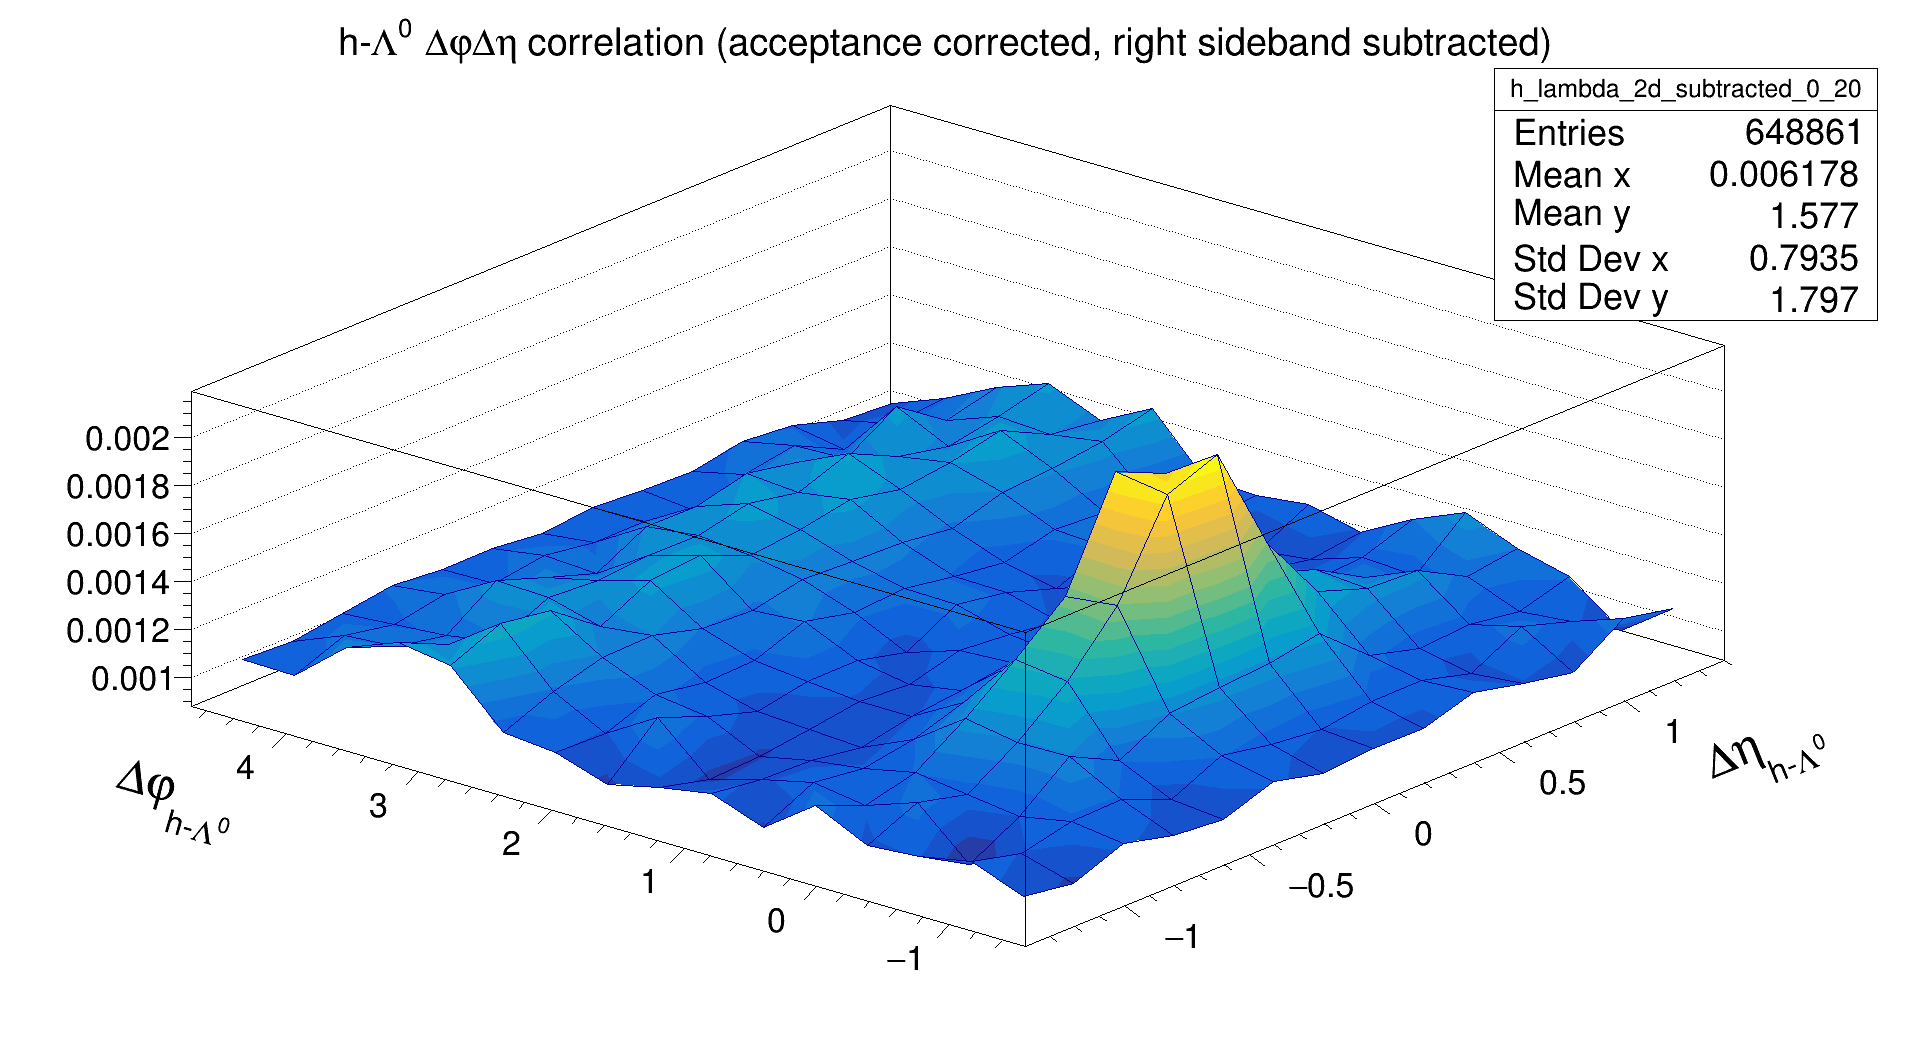

In [63]:
h_lambda_2d_subtracted_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
h_lambda_2d_subtracted_0_20.Draw("SURF1")
c.Draw()

In [85]:
h_lambda_dphi_subtracted_0_20 = h_lambda_2d_subtracted_0_20.ProjectionY("h_lambda_dphi_subtracted_0_20")
h_lambda_dphi_subtracted_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_lambda_dphi_subtracted_0_20.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_0_20.SetLineWidth(3)
h_lambda_dphi_subtracted_0_20.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_0_20.GetXaxis().SetTitleOffset(0.5)

In [105]:
ue_line_0_20 = rt.TF1("ue_line_0_20", "pol0", -2, 6)
ue_upper_line_0_20 = rt.TF1("ue_upper_line_0_20", "pol0", -2, 6)
ue_lower_line_0_20 = rt.TF1("ue_lower_line_0_20", "pol0", -2, 6)
zero_line_0_20 = rt.TF1("ue_line_0_20", "pol0", -2, 6)
zero_upper_line_0_20 = rt.TF1("ue_line_0_20", "pol0", -2, 6)
zero_lower_line_0_20 = rt.TF1("ue_line_0_20", "pol0", -2, 6)
ue_avg_0_20 = (h_lambda_dphi_subtracted_0_20.GetBinContent(1) 
               + h_lambda_dphi_subtracted_0_20.GetBinContent(8)
               + h_lambda_dphi_subtracted_0_20.GetBinContent(9)
               + h_lambda_dphi_subtracted_0_20.GetBinContent(16))/4

ue_avg_error_0_20 = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_0_20.GetBinError(1)**2 
               + h_lambda_dphi_subtracted_0_20.GetBinError(8)**2
               + h_lambda_dphi_subtracted_0_20.GetBinError(9)**2
               + h_lambda_dphi_subtracted_0_20.GetBinError(16)**2))


ue_line_0_20.SetParameter(0, ue_avg_0_20)
ue_line_0_20.SetLineColor(rt.kViolet - 6)
ue_line_0_20.SetLineWidth(3)
ue_line_0_20.SetLineStyle(rt.kSolid)

ue_upper_line_0_20.SetParameter(0, ue_avg_0_20 + ue_avg_error_0_20)
ue_upper_line_0_20.SetLineColor(rt.kViolet - 6)
ue_upper_line_0_20.SetLineStyle(rt.kDashed)

ue_lower_line_0_20.SetParameter(0, ue_avg_0_20 - ue_avg_error_0_20)
ue_lower_line_0_20.SetLineColor(rt.kViolet - 6)
ue_lower_line_0_20.SetLineStyle(rt.kDashed)

zero_line_0_20.SetParameter(0, 0)
zero_line_0_20.SetLineColor(rt.kViolet - 6)
zero_line_0_20.SetLineWidth(3)
zero_line_0_20.SetLineStyle(rt.kSolid)
zero_upper_line_0_20.SetParameter(0, ue_avg_error_0_20)
zero_upper_line_0_20.SetLineColor(rt.kViolet - 6)
zero_upper_line_0_20.SetLineStyle(rt.kDashed)
zero_lower_line_0_20.SetParameter(0, -ue_avg_error_0_20)
zero_lower_line_0_20.SetLineColor(rt.kViolet - 6)
zero_lower_line_0_20.SetLineStyle(rt.kDashed)

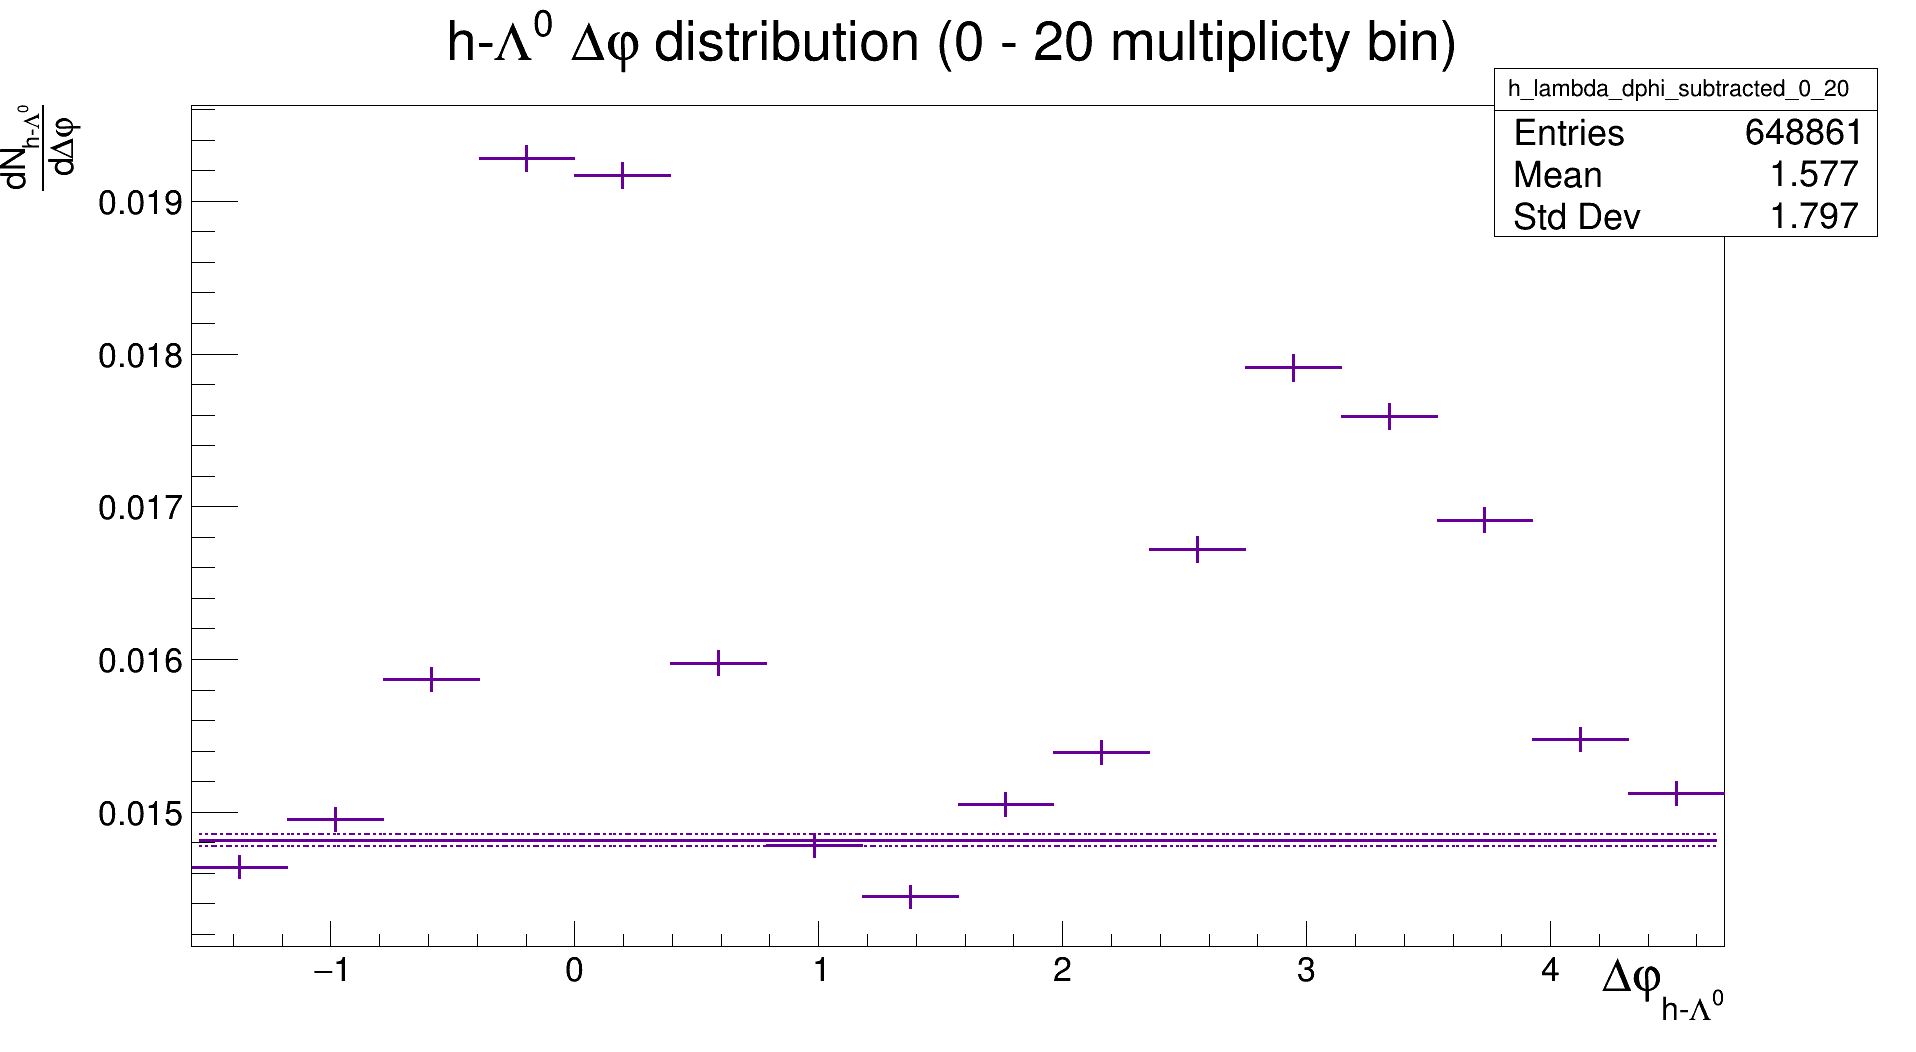

In [102]:
h_lambda_dphi_subtracted_0_20.Draw()
ue_line_0_20.Draw("SAME")
ue_upper_line_0_20.Draw("SAME")
ue_lower_line_0_20.Draw("SAME")
c.Draw()

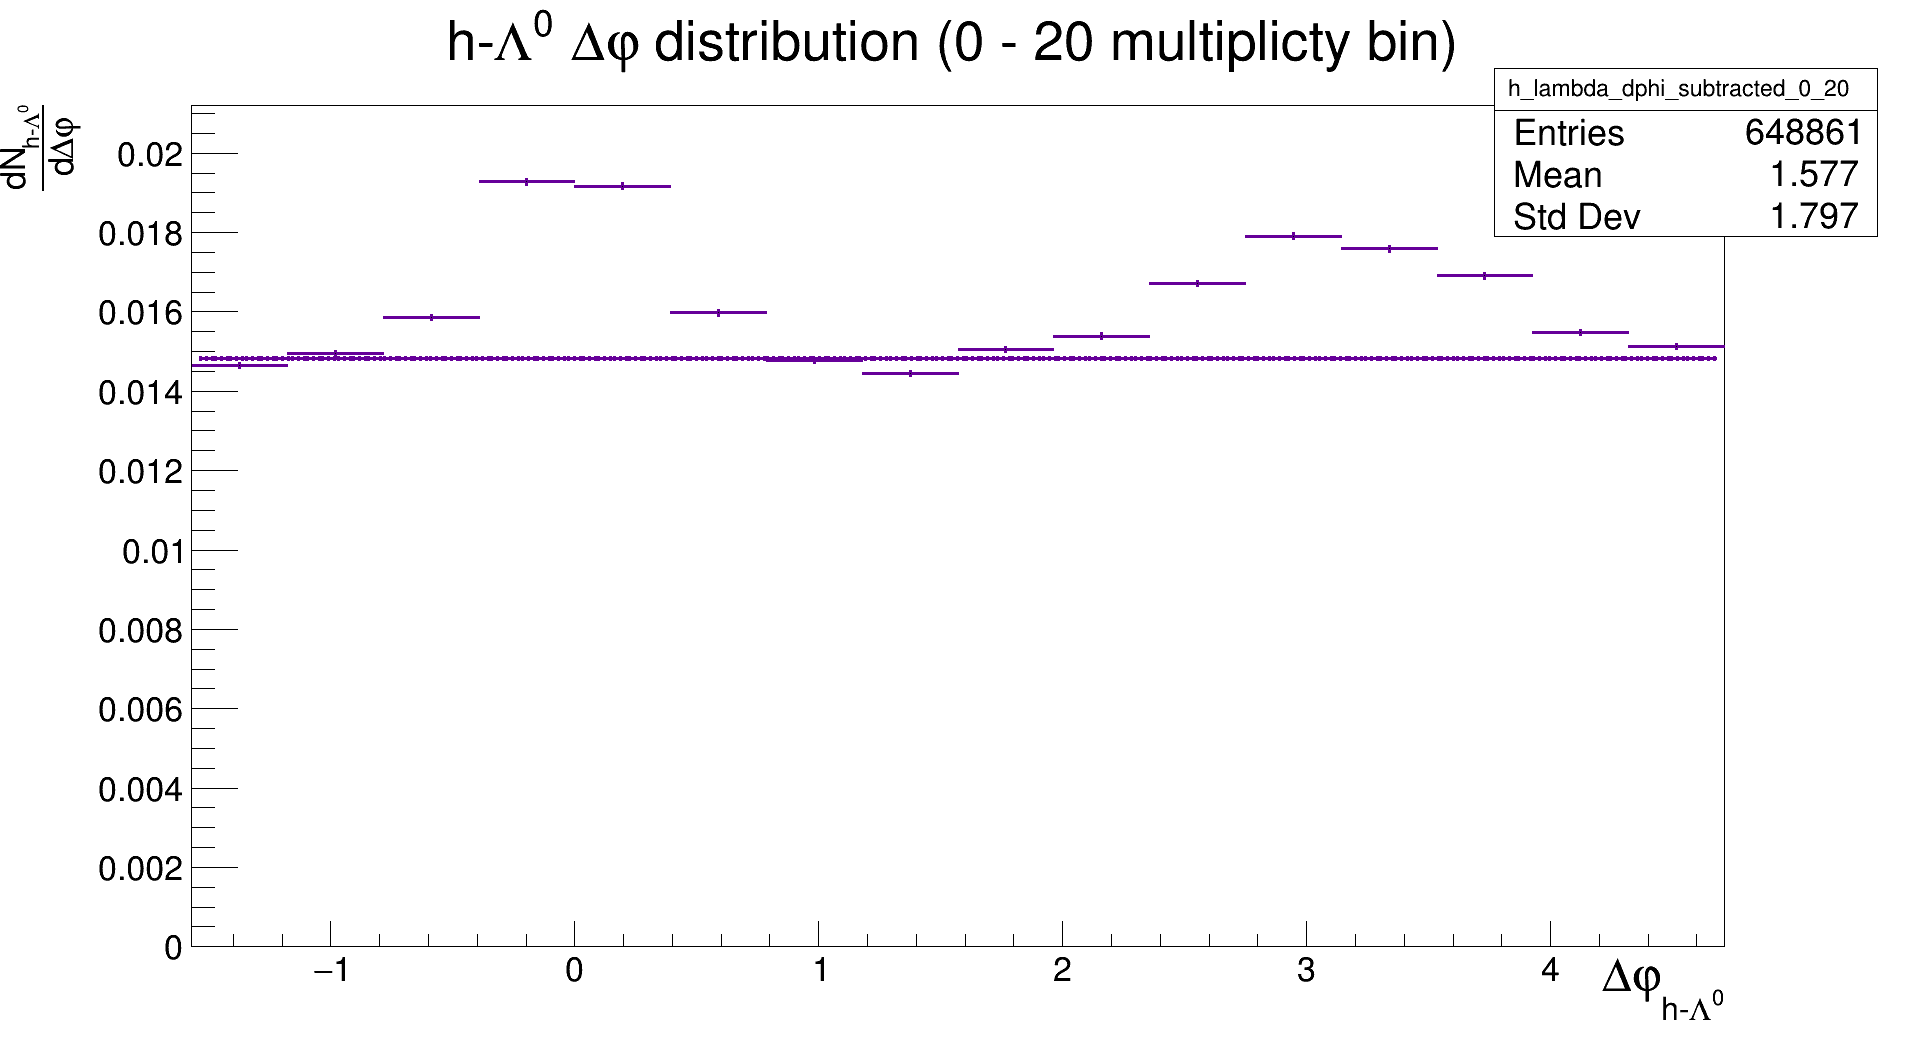

In [103]:
h_lambda_dphi_subtracted_0_20.GetYaxis().SetRangeUser(0, h_lambda_dphi_subtracted_0_20.GetMaximum()*1.1)
h_lambda_dphi_subtracted_0_20.Draw()
ue_line_0_20.Draw("SAME")
ue_upper_line_0_20.Draw("SAME")
ue_lower_line_0_20.Draw("SAME")
c.Draw()

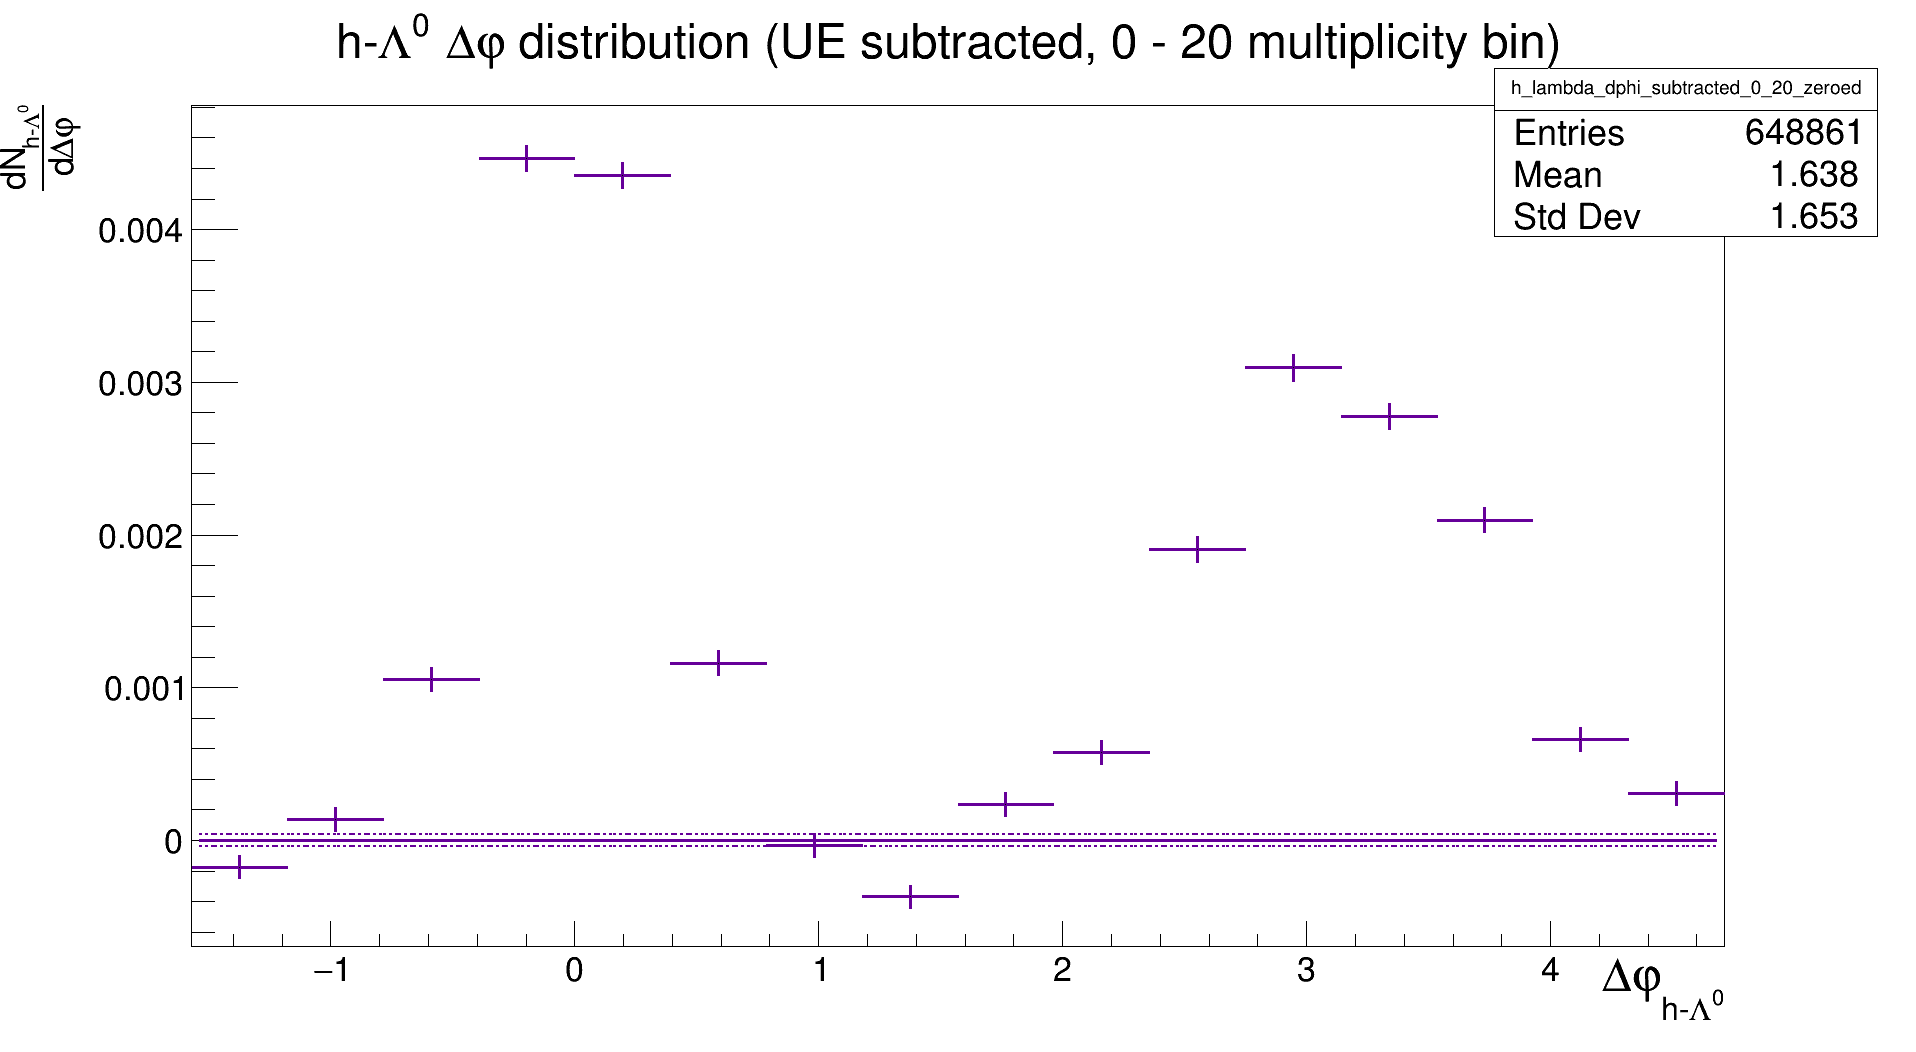

In [107]:
h_lambda_dphi_subtracted_0_20_zeroed = h_lambda_dphi_subtracted_0_20.Clone("h_lambda_dphi_subtracted_0_20_zeroed")
h_lambda_dphi_subtracted_0_20_zeroed.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (UE subtracted, 0 - 20 multiplicity bin)")
h_lambda_dphi_subtracted_0_20_zeroed.Add(ue_line_0_20, -1)
h_lambda_dphi_subtracted_0_20_zeroed.Draw()
zero_line_0_20.Draw("SAME")
zero_upper_line_0_20.Draw("SAME")
zero_lower_line_0_20.Draw("SAME")
c.Draw()

In [108]:
DPHI_BINS = h_lambda_dphi_subtracted_0_20.GetNbinsX()

In [122]:
h_lambda_total_integral_0_20 = 0
h_lambda_ue_integral_0_20 = DPHI_BINS*ue_avg_0_20
h_lambda_ue_integral_0_20_test = 0
h_lambda_near_integral_0_20 = 0
h_lambda_away_integral_0_20 = 0

h_lambda_total_integral_error_0_20 = 0
h_lambda_ue_integral_error_0_20 = 0
h_lambda_near_integral_error_0_20 = 0
h_lambda_away_integral_error_0_20 = 0

## TODO: ADD near/away integrals (only 8 bins each) and their respective errors
for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_0_20 += h_lambda_dphi_subtracted_0_20.GetBinContent(bin_num)
    h_lambda_total_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
    h_lambda_near_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
    h_lambda_near_integral_error_0_20 += ue_avg_error_0_20**2
h_lambda_total_integral_error_0_20 = math.sqrt(h_lambda_total_integral_error_0_20)
h_lambda_near_integral_error_0_20 = math.sqrt(h_lambda_ue_integral_error_0_20)
print(h_lambda_ue_integral_error_0_20)


0.0003570632123429527


# 20 - 50 setup

In [ ]:
input_file_20_50 = rt.TFile("../online/output/cent_20_50.root")
input_list_20_50 = input_file_20_50.Get("h-lambda")
input_file_20_50.Close()

In [ ]:
trig_dist_20_50 = input_list_20_50.FindObject("fTriggerDist")
lambda_dist_20_50 = input_list_20_50.FindObject("fTriggeredLambdaDist")

In [ ]:
h_h_20_50 = input_list_20_50.FindObject("fDphiHHEff")
h_h_mixed_20_50 = input_list_20_50.FindObject("fDphiHHMixed")

In [ ]:
h_lambda_20_50 = input_list_20_50.FindObject("fDphiHLambdaEff")
h_lambda_ls_20_50 = input_list_20_50.FindObject("fDphiHLambdaLS")
h_lambda_mixed_20_50 = input_list_20_50.FindObject("fDphiHLambdaMixed")
h_lambda_ls_mixed_20_50 = input_list_20_50.FindObject("fDphiHLambdaLSMixed")

In [ ]:
# Setting the trigger Pt (this is never changed again)
trig_dist_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [ ]:
# Setting the associated Pt (this is never changed again)
lambda_dist_20_50.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_mixed_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [ ]:
trig_pt_dist_20_50 = trig_dist_20_50.Projection(0).Clone("trig_pt_dist_20_50")
trig_phi_dist_20_50 = trig_dist_20_50.Projection(1).Clone("trig_phi_dist_20_50")
trig_eta_dist_20_50 = trig_dist_20_50.Projection(2).Clone("trig_eta_dist_20_50")

trig_pt_dist_20_50.SetTitle("Trigger #font[12]{p}_{T} Distribution (Hybrid GCG)")
trig_pt_dist_20_50.Sumw2()
trig_pt_dist_20_50.SetLineColor(rt.kRed)

trig_phi_dist_20_50.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_20_50.Sumw2()
trig_phi_dist_20_50.SetLineColor(rt.kRed)

trig_eta_dist_20_50.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_20_50.Sumw2()
trig_eta_dist_20_50.SetLineColor(rt.kRed)

In [ ]:
trig_pt_dist_20_50.Draw()
c.Draw()

In [ ]:
trig_eta_dist_20_50.Draw()
c.Draw()

In [ ]:
trig_phi_dist_20_50.GetYaxis().SetRangeUser(0, 600e3)
trig_phi_dist_20_50.Draw()
c.Draw()

### Signal analysis section

In [ ]:
# eta cuts first
lambda_dist_20_50.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_mass_dist_20_50 = lambda_dist_20_50.Projection(3).Clone("lambda_mass_dist_20_50")

In [ ]:
lambda_mass_dist_20_50.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist_20_50.Sumw2()
lambda_mass_dist_20_50.SetLineWidth(2)
lambda_mass_dist_20_50.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist_20_50.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

In [ ]:
lambda_mass_dist_20_50.Draw()
c.Draw()

In [ ]:
bin_1 = lambda_mass_dist_20_50.FindBin(1.09)
bin_2 = lambda_mass_dist_20_50.FindBin(1.15)
bin_3 = lambda_mass_dist_20_50.FindBin(1.16 - EPSILON)
point_one = [1.09, lambda_mass_dist_20_50.GetBinContent(bin_1)]
point_two = [1.15, lambda_mass_dist_20_50.GetBinContent(bin_2)]
point_three = [1.16, lambda_mass_dist_20_50.GetBinContent(bin_3)]
bg_starting_params_20_50 = get_parabola(point_one, point_two, point_three)

In [ ]:
lambda_mass_fit_20_50.Delete()

In [ ]:
lambda_mass_fit_20_50 = rt.TF1("lambda_mass_fit_20_50", "[0]*TMath::Voigt(x - [1], [2], [3], 4) + pol2(4)", 1.09, 1.155)
lambda_mass_fit_20_50.SetNpx(1000)
lambda_mass_fit_20_50.SetParameter(0, 1.36753e01)
lambda_mass_fit_20_50.SetParameter(1, 1.11581)
lambda_mass_fit_20_50.SetParameter(2, 1.00576e-05 )
lambda_mass_fit_20_50.SetParameter(3, 6.04166e-03)
lambda_mass_fit_20_50.SetParameter(4, bg_starting_params_20_50[0])
lambda_mass_fit_20_50.SetParameter(5, bg_starting_params_20_50[1])
lambda_mass_fit_20_50.SetParameter(6, bg_starting_params_20_50[2])

In [ ]:
lambda_mass_dist_fit_20_50 = lambda_mass_dist_20_50.Clone("lambda_mass_dist_fit_20_50")
lambda_mass_dist_fit_20_50.Fit(lambda_mass_fit_20_50, "RS")
lambda_mass_dist_fit_20_50.Draw()
c.Draw()

In [ ]:
bg_fit_20_50 = rt.TF1("bg_fit_20_50", "pol2", 1.09, 1.15)
bg_fit_20_50.SetParameter(0, lambda_mass_fit_20_50.GetParameter(4))
bg_fit_20_50.SetParameter(1, lambda_mass_fit_20_50.GetParameter(5))
bg_fit_20_50.SetParameter(2, lambda_mass_fit_20_50.GetParameter(6))
bg_fit_20_50.SetNpx(1000)
bg_fit_20_50.SetLineColor(rt.kMagenta)
lambda_mass_dist_fit_20_50.Draw()
bg_fit_20_50.Draw("SAME")
c.Draw()

In [ ]:
left_signal_bin_20_50 = lambda_mass_dist_fit_20_50.FindBin(SIG_MIN)
right_signal_bin_20_50 = lambda_mass_dist_fit_20_50.FindBin(SIG_MAX)

lambda_bg_20_50 = 0
lambda_total_20_50 = 0
for bin_num in range(left_signal_bin_20_50, right_signal_bin_20_50 + 1):
    bin_center = lambda_mass_dist_fit_20_50.GetBinCenter(bin_num)
    lambda_bg_20_50 += bg_fit_20_50.Eval(bin_center)
    lambda_total_20_50 += lambda_mass_dist_fit_20_50.GetBinContent(bin_num)

lambda_signal_20_50 = lambda_total_20_50 - lambda_bg_20_50
lambda_signal_total_ratio_20_50 = lambda_signal_20_50/lambda_total_20_50
lambda_signal_bg_ratio_20_50 = lambda_signal_20_50/lambda_bg_20_50
print(f"The 20-50 lambda signal is: {lambda_signal_20_50}")
print(f"The 20-50 lambda background is: {lambda_bg_20_50}")
print(f"The 20-50 lambda S/B is: {lambda_signal_bg_ratio_20_50}")
print(f"The 20-50 lambda S/T is: {lambda_signal_total_ratio_20_50}")
print(f"The 20-50 lambda significance is: {lambda_signal_20_50/math.sqrt(lambda_signal_20_50 + lambda_bg_20_50)}")

### Mixed event correction section

In [ ]:
axes = arr.array('i', [2, 3, 4, 5])
h_lambda_20_50 = h_lambda_20_50.Projection(4, axes)
h_lambda_ls_20_50 = h_lambda_ls_20_50.Projection(4, axes)
h_lambda_mixed_20_50 = h_lambda_mixed_20_50.Projection(4, axes)
h_lambda_ls_mixed_20_50 = h_lambda_ls_mixed_20_50.Projection(4, axes)

In [ ]:
h_h_20_50 = h_h_20_50.Projection(2, 3, 4)
h_h_mixed_20_50 = h_h_mixed_20_50.Projection(2, 3, 4)
h_h_20_50.Sumw2()
h_h_mixed_20_50.Sumw2()

In [ ]:
# Setting up 2-d correlation plots before the mixed event correction
h_lambda_2d_nomixcor_20_50 = h_lambda_20_50.Projection(0, 1).Clone("h_lambda_2d_nomixcor_20_50")
h_lambda_ls_2d_nomixcor_20_50 = h_lambda_ls_20_50.Projection(0, 1).Clone("h_lambda_ls_2d_nomixcor_20_50")
h_lambda_mixed_2d_20_50 = h_lambda_mixed_20_50.Projection(0, 1).Clone("h_lambda_mixed_2d_20_50")

In [ ]:
h_h_2d_nomixcor_20_50 = h_h_20_50.Project3D("xye").Clone("h_h_2d_nomixcor_20_50")
h_h_mixed_2d_20_50 = h_h_mixed_20_50.Project3D("xye").Clone("h_h_mixed_2d_20_50")

In [ ]:
h_lambda_2d_nomixcor_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_2d_nomixcor_20_50.GetXaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_20_50.GetYaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_20_50.GetYaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_20_50.SetTitle("h-#Lambda^{0} (LS) #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_ls_2d_nomixcor_20_50.GetXaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_20_50.GetYaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_20_50.GetYaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_20_50.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta")
h_lambda_mixed_2d_20_50.GetXaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_20_50.GetYaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_20_50.GetYaxis().SetTitleOffset(1.3)

In [ ]:
h_h_2d_nomixcor_20_50.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction)")
h_h_2d_nomixcor_20_50.GetXaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_20_50.GetYaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_20_50.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_20_50.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_20_50.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_20_50.GetYaxis().SetTitleOffset(1.3)
h_h_mixed_2d_20_50.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_20_50.GetXaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_20_50.GetYaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_20_50.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_20_50.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_20_50.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_20_50.GetYaxis().SetTitleOffset(1.3)

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_20_50.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_ls_2d_nomixcor_20_50.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_mixed_2d_20_50.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_nomixcor_20_50.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_h_mixed_2d_20_50.Draw("SURF1")
c.Draw()

# 50 - 80 setup

In [ ]:
input_file_50_80 = rt.TFile("../online/output/cent_50_80.root")
input_list_50_80 = input_file_50_80.Get("h-lambda")
input_file_50_80.Close()

In [ ]:
trig_dist_50_80 = input_list_50_80.FindObject("fTriggerDist")
lambda_dist_50_80 = input_list_50_80.FindObject("fTriggeredLambdaDist")

In [ ]:
h_h_50_80 = input_list_50_80.FindObject("fDphiHHEff")
h_h_mixed_50_80 = input_list_50_80.FindObject("fDphiHHMixed")

In [ ]:
h_lambda_50_80 = input_list_50_80.FindObject("fDphiHLambdaEff")
h_lambda_ls_50_80 = input_list_50_80.FindObject("fDphiHLambdaLS")
h_lambda_mixed_50_80 = input_list_50_80.FindObject("fDphiHLambdaMixed")
h_lambda_ls_mixed_50_80 = input_list_50_80.FindObject("fDphiHLambdaLSMixed")

In [ ]:
# Setting the trigger Pt (this is never changed again)
trig_dist_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_mixed_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [ ]:
# Setting the associated Pt (this is never changed again)
lambda_dist_50_80.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_mixed_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [ ]:
trig_pt_dist_50_80 = trig_dist_50_80.Projection(0).Clone("trig_pt_dist_50_80")
trig_phi_dist_50_80 = trig_dist_50_80.Projection(1).Clone("trig_phi_dist_50_80")
trig_eta_dist_50_80 = trig_dist_50_80.Projection(2).Clone("trig_eta_dist_50_80")

trig_pt_dist_50_80.SetTitle("Trigger #font[12]{p}_{T} Distribution (Hybrid GCG)")
trig_pt_dist_50_80.Sumw2()
trig_pt_dist_50_80.SetLineColor(rt.kRed)

trig_phi_dist_50_80.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_50_80.Sumw2()
trig_phi_dist_50_80.SetLineColor(rt.kRed)

trig_eta_dist_50_80.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_50_80.Sumw2()
trig_eta_dist_50_80.SetLineColor(rt.kRed)

In [ ]:
trig_pt_dist_50_80.Draw()
c.Draw()

In [ ]:
trig_eta_dist_50_80.Draw()
c.Draw()

In [ ]:
trig_phi_dist_50_80.GetYaxis().SetRangeUser(0, 200e3)
trig_phi_dist_50_80.Draw()
c.Draw()

In [ ]:
# eta cuts first
lambda_dist_50_80.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_mass_dist_50_80 = lambda_dist_50_80.Projection(3).Clone("lambda_mass_dist_50_80")

In [ ]:
lambda_mass_dist_50_80.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist_50_80.Sumw2()
# lambda_mass_dist_50_80.Rebin(2)
lambda_mass_dist_50_80.SetLineWidth(2)
lambda_mass_dist_50_80.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist_50_80.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

In [ ]:
lambda_mass_dist_50_80.Draw()
c.Draw()

In [ ]:
bin_1 = lambda_mass_dist_50_80.FindBin(1.09)
bin_2 = lambda_mass_dist_50_80.FindBin(1.15)
bin_3 = lambda_mass_dist_50_80.FindBin(1.16 - EPSILON)
point_one = [1.09, lambda_mass_dist_50_80.GetBinContent(bin_1)]
point_two = [1.15, lambda_mass_dist_50_80.GetBinContent(bin_2)]
point_three = [1.16, lambda_mass_dist_50_80.GetBinContent(bin_3)]
bg_starting_params_50_80 = get_parabola(point_one, point_two, point_three)

In [ ]:
lambda_mass_fit_50_80.Delete()

In [ ]:
lambda_mass_fit_50_80 = rt.TF1("lambda_mass_fit_50_80", "[0]*TMath::Voigt(x - [1], [2], [3], 4) + pol2(4)", 1.09, 1.155)
lambda_mass_fit_50_80.SetNpx(1000)
lambda_mass_fit_50_80.SetParameter(0, 1.36753e01)
lambda_mass_fit_50_80.SetParameter(1, 1.11581)
lambda_mass_fit_50_80.SetParameter(2, 1.00576e-05 )
lambda_mass_fit_50_80.SetParameter(3, 6.04166e-03)
lambda_mass_fit_50_80.SetParameter(4, bg_starting_params_50_80[0])
lambda_mass_fit_50_80.SetParameter(5, bg_starting_params_50_80[1])
lambda_mass_fit_50_80.SetParameter(6, bg_starting_params_50_80[2])

In [ ]:
lambda_mass_dist_fit_50_80 = lambda_mass_dist_50_80.Clone("lambda_mass_dist_fit_50_80")
lambda_mass_dist_fit_50_80.Fit(lambda_mass_fit_50_80, "RS")
lambda_mass_dist_fit_50_80.Draw()
c.Draw()

In [ ]:
bg_fit_50_80 = rt.TF1("bg_fit_50_80", "pol2", 1.09, 1.15)
bg_fit_50_80.SetParameter(0, lambda_mass_fit_50_80.GetParameter(4))
bg_fit_50_80.SetParameter(1, lambda_mass_fit_50_80.GetParameter(5))
bg_fit_50_80.SetParameter(2, lambda_mass_fit_50_80.GetParameter(6))
bg_fit_50_80.SetNpx(1000)
bg_fit_50_80.SetLineColor(rt.kMagenta)
lambda_mass_dist_fit_50_80.Draw()
bg_fit_50_80.Draw("SAME")
c.Draw()

In [ ]:
left_signal_bin_50_80 = lambda_mass_dist_fit_50_80.FindBin(SIG_MIN)
right_signal_bin_50_80 = lambda_mass_dist_fit_50_80.FindBin(SIG_MAX)

lambda_bg_50_80 = 0
lambda_total_50_80 = 0
for bin_num in range(left_signal_bin_50_80, right_signal_bin_50_80 + 1):
    bin_center = lambda_mass_dist_fit_50_80.GetBinCenter(bin_num)
    lambda_bg_50_80 += bg_fit_50_80.Eval(bin_center)
    lambda_total_50_80 += lambda_mass_dist_fit_50_80.GetBinContent(bin_num)

lambda_signal_50_80 = lambda_total_50_80 - lambda_bg_50_80
lambda_signal_total_ratio_50_80 = lambda_signal_50_80/lambda_total_50_80
lambda_signal_bg_ratio_50_80 = lambda_signal_50_80/lambda_bg_50_80
print(f"The 50-80 lambda signal is: {lambda_signal_50_80}")
print(f"The 50-80 lambda background is: {lambda_bg_50_80}")
print(f"The 50-80 lambda S/B is: {lambda_signal_bg_ratio_50_80}")
print(f"The 50-80 lambda S/T is: {lambda_signal_total_ratio_50_80}")
print(f"The 50-80 lambda significance is: {lambda_signal_50_80/math.sqrt(lambda_signal_50_80 + lambda_bg_50_80)}")

In [ ]:
axes = arr.array('i', [2, 3, 4, 5])